## Prediction dataGen


In [3]:
class DataGenPredict(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=1, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name) + ".png"
   
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))      

        ## Normalizaing 
        image = image/255.0
        
        return image
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        
        for id_name in files_batch:
            _img= self.__load__(id_name)
            image.append(_img)
            
        image = np.array(image)     
        return image
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [4]:
image_size = 128
train_path = "./palps/" #changed this by mistake,check if running again
epochs = 150
batch_size = 5
from os import path
import random
# path.exists("./train_subset/")
## Training Ids
# train_ids  = np.arange(1,31)*10
# train_ids = next(os.walk(train_path))[1]


fnames = os.listdir(train_path)
train_ids = []
for file in fnames:
    train_ids.append(file[:file.index(".")])
    
## Validation Data Size
val_data_size = 10
train_ids = np.unique(np.asarray(train_ids).astype(str))
np.random.shuffle(train_ids) # shuffle the order so that validation, test, train are all randomized frames
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

print(train_ids)

['836' '802' '792' '233' '574' '571' '162' '41' '124' '673' '892' '26'
 '731' '721' '36' '702' '604' '816' '742' '431' '871' '616' '684' '432'
 '763' '831' '861' '581' '244' '486' '752' '324' '606' '46' '6' '71' '241'
 '671' '774' '553' '526' '876' '654' '634' '513' '713' '223' '236' '542'
 '452' '141' '523' '733' '262' '16' '682' '251' '703' '603' '883' '483'
 '593' '204' '562' '1' '104' '94' '61' '691' '692' '672' '64' '4' '454'
 '736' '56' '843' '304' '213' '421' '662' '352' '31' '226' '383' '504'
 '402' '363' '206' '493']


In [5]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(2)
print(x.shape, y.shape)

(5, 128, 128, 3) (5, 128, 128, 1)


In [6]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [7]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [80]:
model = UNet()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [9]:
# train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
# valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

# train_steps = len(train_ids)//batch_size
# valid_steps = len(valid_ids)//batch_size

# history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
#                     epochs=epochs,verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 18 steps, validate for 2 steps
Epoch 1/150
18/18 - 8s - loss: 0.6121 - acc: 0.5393 - val_loss: 0.1142 - val_acc: 0.9936
Epoch 2/150
18/18 - 7s - loss: 0.0653 - acc: 0.9937 - val_loss: 0.0504 - val_acc: 0.9942
Epoch 3/150
18/18 - 7s - loss: 0.0339 - acc: 0.9939 - val_loss: 0.0283 - val_acc: 0.9943
Epoch 4/150
18/18 - 7s - loss: 0.0226 - acc: 0.9939 - val_loss: 0.0185 - val_acc: 0.9943
Epoch 5/150
18/18 - 7s - loss: 0.0149 - acc: 0.9939 - val_loss: 0.0118 - val_acc: 0.9943
Epoch 6/150
18/18 - 7s - loss: 0.0107 - acc: 0.9939 - val_loss: 0.0094 - val_acc: 0.9943
Epoch 7/150
18/18 - 7s - loss: 0.0094 - acc: 0.9939 - val_loss: 0.0089 - val_acc: 0.9943
Epoch 8/150
18/18 - 7s - loss: 0.0090 - acc: 0.9939 - val_loss: 0.0080 - val_acc: 0.9943
Epoch 9/150
18/18 - 7s - loss: 0.0082 - acc: 0.9939 - val_loss: 0.0076 - val_acc: 0.9943
Epoch 10/150
18/18 - 7s - loss: 0.0076 - acc: 0.9939 - val_loss: 0.0067 - val_acc: 0.9943
Epoch 11/150
18/18

Epoch 90/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 91/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 92/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 93/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 94/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 95/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 96/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 97/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 98/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 99/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 100/150
18/18 - 7s - loss: 0.0045 - acc: 0.9939 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 101

In [127]:
# ## Save the Weights
# model.save_weights("UNetW.h5")

# ## Dataset for prediction
# # x, y = valid_gen.__getitem__(0)
# x, y = gen.__getitem__(0)
# result = model.predict(x)

# # result = result > 0.15

# # fig = plt.figure()
# # fig.subplots_adjust(hspace=0.4, wspace=0.4)

# # ax = fig.add_subplot(1, 2, 1)
# # ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

# # ax = fig.add_subplot(1, 2, 2)
# # plt.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")
# # # plt.colorbar()

# Loading the trained weights

In [9]:
model.load_weights("UNetW.h5")

NameError: name 'result' is not defined

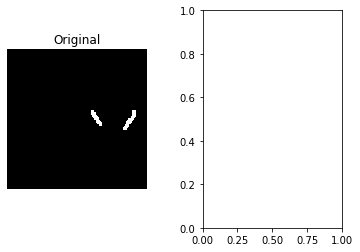

In [11]:
# fig = plt.figure()
# fig.subplots_adjust(hspace=0.4, wspace=0.4)

# ax = fig.add_subplot(1, 2, 1)
# ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")
# ax.axis('off')
# ax.set_title('Original')
# ax = fig.add_subplot(1, 2, 2)
# ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [12]:
# from skimage.io import imread, imshow
# from skimage.filters import gaussian, threshold_otsu
# from skimage import measure
# import matplotlib.pyplot as plt

# tracked = result[0].squeeze()
# blurred = gaussian(tracked, sigma=0.1)
# blurred = tracked
# binary = blurred > threshold_otsu(blurred)
# labels = measure.label(binary,connectivity = 1)

# plots = {'Tracked': tracked, 'Blurred': blurred, 
#          'Binary': binary, 'Labels': labels}
# fig, ax = plt.subplots(1, len(plots),figsize=(20,10))

# for n, (title, img) in enumerate(plots.items()):
#     cmap = plt.cm.gnuplot if n == len(plots) - 1 else plt.cm.gray
#     ax[n].imshow(img, cmap=cmap)
#     ax[n].axis('off')
#     ax[n].set_title(title)
# plt.show(fig)

# props = measure.regionprops(labels)
# for prop in props:
#     print('Label: {} >> Object size: {}'.format(prop.label, prop.area))
    

NameError: name 'result' is not defined

## Load a new video as frames

In [17]:
image_size = 128


file_name  = 'OdorALocust6Trial1_t1' #palps is test video 1,rest are in test_videos folder. 
train_path = './'  +  file_name +  '/'

# file_name = 'OdorALocust6Trial1_t1'
# train_path = './test_videos/'  +  file_name +  '/'

# epochs = 200
batch_size = 1
nframes = 900
from os import path
import random
## Training Ids
train_ids = np.arange(1,nframes+1).astype(str)
# print(train_ids)

gen2 = DataGenPredict(train_ids, train_path, batch_size=batch_size, image_size=image_size)

## Select a bounding region using figure below

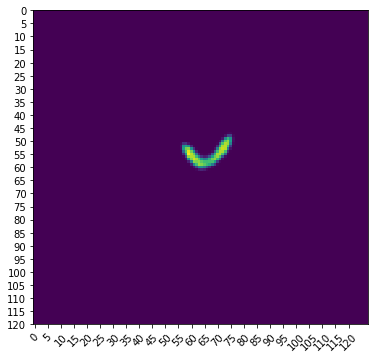

In [11]:
final_coords = [0]

#short loop to get bounding for a video
for i in range(1):
    x= gen2.__getitem__(400)
    result = model.predict(x)
    tracked = result[0].squeeze()
    fig, ax = plt.subplots(1,1,figsize= (6,6))
    ax.imshow(tracked)
    ax.set_xticks(np.arange(0, 125, 5))
    ax.set_yticks(np.arange(0, 125, 5))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    ax.xaxis.set_tick_params(rotation=45)
    plt.show()

## Select threshold and apply model to frames
## Consider splitting these steps since applying the model takes most of the time. Should not re-do


In [82]:
t = time.time()
top = 35
left = 15
bottom = 75
right = 120
final_coords = [0]
top,bottom,left,right = 20,120,20,120

for i in range(nframes):
    x= gen2.__getitem__(i)
    result = model.predict(x)
    for batch_number in range(batch_size):
        tracked = result[batch_number].squeeze()
        blurred = tracked[20:120,20:120] #ignoring edge cases which were producing noisy results.
        blurred = tracked[top:bottom,left:right]
        binary = blurred > threshold_triangle(blurred) #li works best? or does triangle work with bounds
        labels = measure.label(binary,connectivity = 2)
        
        props = measure.regionprops(labels)
        
        if len(props)==1:
            split = props[0].centroid[1]
            binary[:,np.round(split).astype(int)] = 0
            labels = measure.label(binary,connectivity = 2)
        props = measure.regionprops(labels)
        if len(props)>1:
            #find the largest two areas, then find pdist between them
            coords = []
            for ii,prop in enumerate(props):
                coords.append(prop.centroid)
            coords = np.array(coords)
#             print(scipy.spatial.distance.pdist(coords))
            final_coords.append(scipy.spatial.distance.pdist(coords[0:2]))
        if i%100==0:
            print('{} frames done!'.format(i))


0 frames done!
100 frames done!
200 frames done!
300 frames done!
400 frames done!
500 frames done!
600 frames done!
700 frames done!
800 frames done!


## Plotting and saving the data

Total time taken for this video is 45.26 seconds


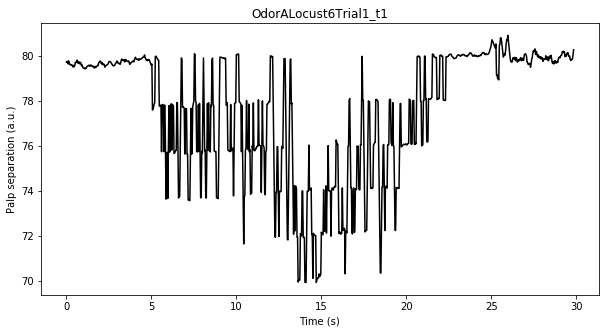

In [83]:
plt.close()
fig, ax = plt.subplots(figsize=(10,5))
N =5 # points to smooth
f = np.concatenate(final_coords[1:], axis=0) #convert list of arrays to 1 np array
# ax.plot(np.arange(1,1196)/30,final_coords[1:],'k')
# ax.plot(np.arange(nframes)/30,final_coords[1:],'k')
ax.plot(np.arange(nframes-N+1)/30,np.convolve(f, np.ones((N,))/N, mode='valid'),'k')
p = matplotlib.patches.Rectangle((19.5,0), 4, 45,alpha = 0.5)
ax.add_patch(p)
# p = matplotlib.patches.Rectangle((15,0), 4, 45,alpha = 0.5,color = 'r')
# ax.add_patch(p)
plt.xlabel('Time (s)')
plt.ylabel('Palp separation (a.u.)')
# plt.xlim((5, 25))
plt.title(file_name)
fname = train_path[:-1]+'.png'
fname_csv = train_path[:-1]+'.csv'
plt.savefig(fname)
np.savetxt(fname_csv, final_coords, delimiter=",")
print("Total time taken for this video is {:.2f} seconds".format(time.time()-t))

[ 77.18298722  64.67736217  67.09336394  50.06433887  68.27425188
  62.29062855  15.88059513  54.43841453  69.68697458 114.19300724
  94.27559248  57.37524207  66.98673169 109.7363004   91.56101656
  25.26716276  67.32563178  45.21138836  44.91029407  24.70097714
  22.28820915]


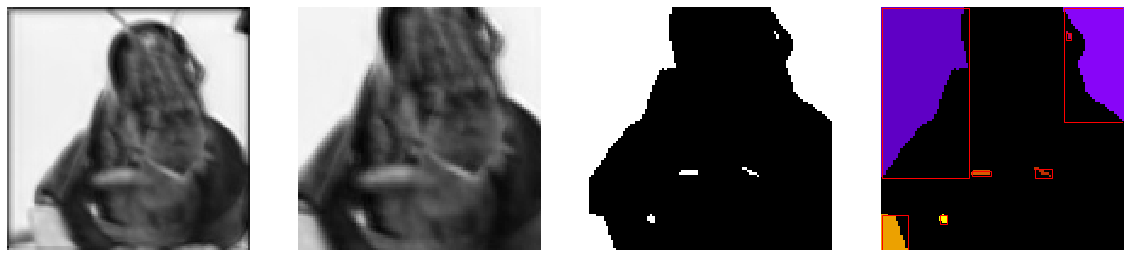

[ 77.19439824  64.66934072  67.62455409  49.7146787   68.22470169
  62.24194258  16.24125914  54.4242961   70.57822967 114.16015529
  94.14636712  57.96904346  68.06870621 109.97683921  91.76915672
  26.7783679   67.67091217  45.42590808  43.91161116  23.76263877
  22.39947293]


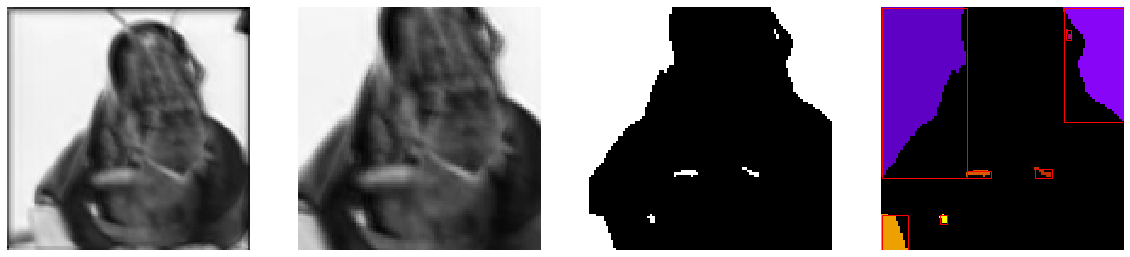

[ 47.31694641  77.17830296  64.69816332  67.40664588  49.71380241
  68.32496222  62.29258948  41.47316354  25.64555409  68.74305801
  69.14367401 105.53054973  91.11505433  15.85042615  54.49674561
  70.57457414 114.24190311  94.13680355  57.5118882   67.73493388
 109.79833267  91.44842391  26.53543465  67.52680892  45.19255144
  43.99263331  23.7635652   22.49580112]


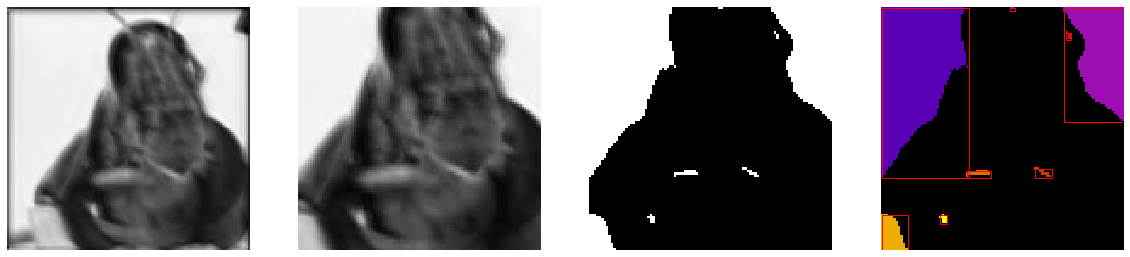

[ 47.35159556  77.22442326  64.67750618  66.49359494  49.86465679
  68.16674227  62.26679587  41.48954856  25.28339376  68.0661443
  68.93512641 105.41740118  91.11505433  16.25978563  54.34342993
  70.15990823 114.1765182   94.15597607  57.56083738  67.70210026
 109.96447974  91.76915672  25.32617794  67.0187422   44.77949447
  44.38697568  24.15631398  22.45533375]


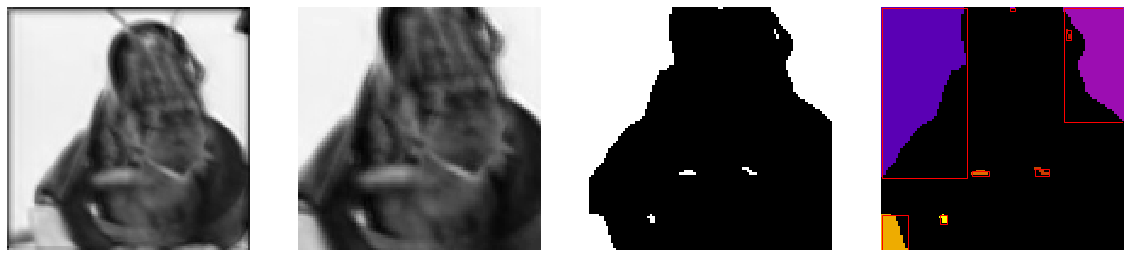

[ 47.29933205  77.20523225  64.67776659  67.10392444  49.94829106
  68.22183964  62.28859249  41.50174998  25.64555409  68.52474462
  68.8380749  105.41920418  91.11505433  15.87714936  54.47924215
  69.98648808 114.19170514  94.18777318  57.37524207  67.19922701
 109.69097977  91.44842391  25.58418158  67.30616536  45.06800417
  44.58873954  24.3436408   22.42039543]


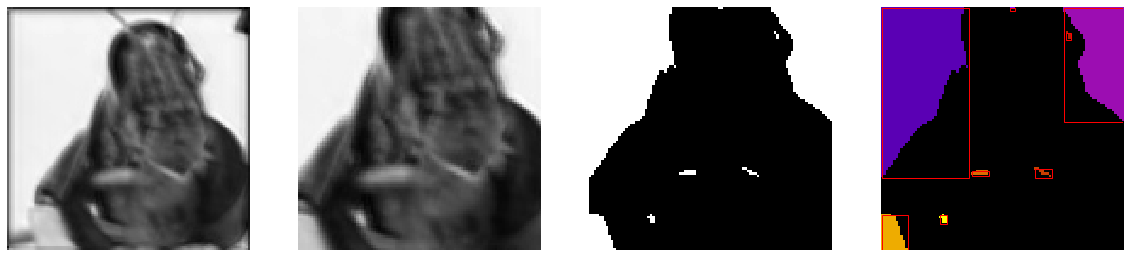

[ 77.14042241  64.77320619  67.20153887  49.74792246  68.20207707
  62.25750543  15.9287307   54.23241536  70.17263117 114.13443536
  94.15575361  57.4855803   67.62036878 109.9103659   91.7020481
  26.15698313  67.56517026  45.35829155  44.31190687  24.15461321
  22.3870081 ]


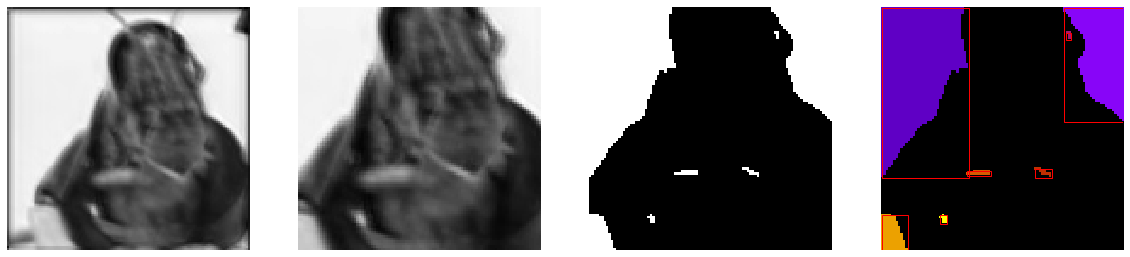

[ 46.90476387  77.20032418  64.63770393  66.58705649  50.16682501
  68.2144445   62.23424303  41.9570397   25.73907535  68.30961925
  68.64122192 105.23806411  90.96127267  16.2802808   54.44260345
  69.59191402 114.22782409  94.16677514  57.68749378  67.24934565
 110.01044513  91.76915672  24.64658357  67.04979036  44.78137439
  45.07199809  24.67501137  22.4684444 ]


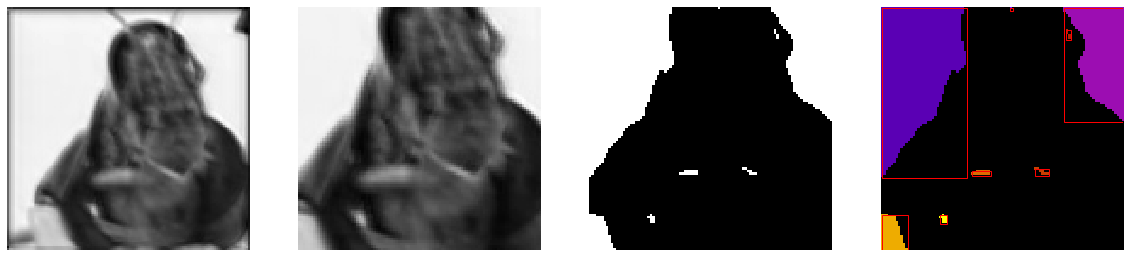

[ 46.93699959  77.21059662  64.7845241   67.36920391  50.06323483
  68.19742228  62.2107359   41.95235328  25.78992051  68.74976992
  68.72641069 105.22317977  90.96127267  16.24198213  54.35127455
  69.77443421 114.16714041  94.14991996  57.96096175  67.54970469
 110.11798124  91.90796007  25.64159544  67.57513476  45.34020279
  44.80099344  24.49143409  22.39947293]


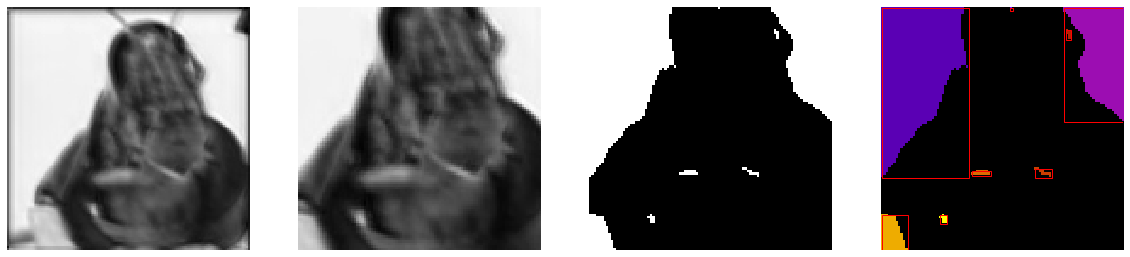

[ 47.34286207  77.20472261  64.8411279   67.37889917  50.03167859
  68.15453323  62.23031432  41.50579694  25.61493705  68.65455215
  68.72946158 105.40318574  91.11505433  15.93461042  54.35127455
  69.68770505 114.12935645  94.14991996  57.64344694  67.24245104
 109.9103659   91.7020481   25.60015432  67.55626034  45.34020279
  44.84938321  24.58099565  22.3870081 ]


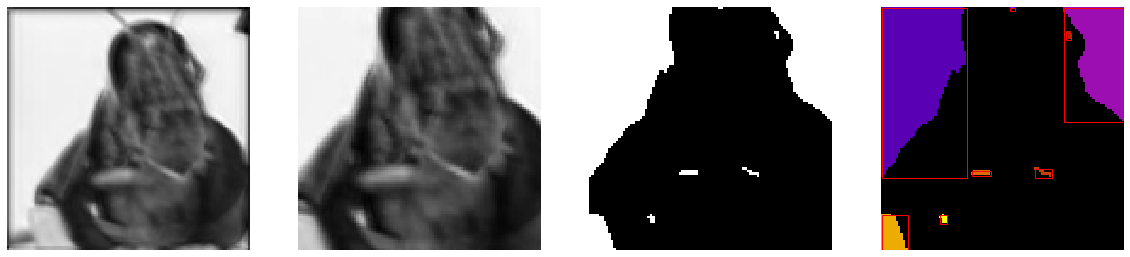

[ 77.21890135  64.76648861  67.24675588  49.78146125  68.1764007
  62.38737022  16.23503228  54.2654688   70.34340753 114.20845862
  94.12855337  57.80276524  67.96345423 110.10563173  91.88245374
  26.27568052  67.62820007  45.23515515  44.22032118  23.98204166
  22.60219579]


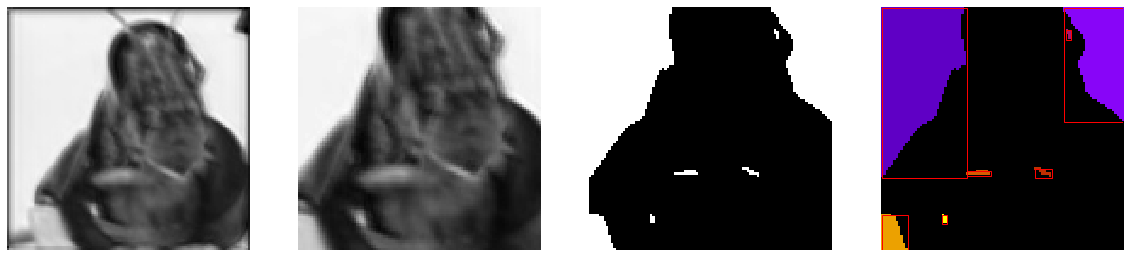

[ 46.91550952  77.23911729  64.77765558  67.38296721  49.652424
  68.18241978  62.2561339   41.94722413  25.78992051  68.83734631
  68.80552752 105.18409645  90.96127267  16.23204804  54.56341137
  70.32672105 114.2117419   94.20868022  58.0900663   67.89983272
 110.09574014  91.90796007  26.27777778  67.44364593  45.19255144
  44.21701634  24.07426861  22.42039543]


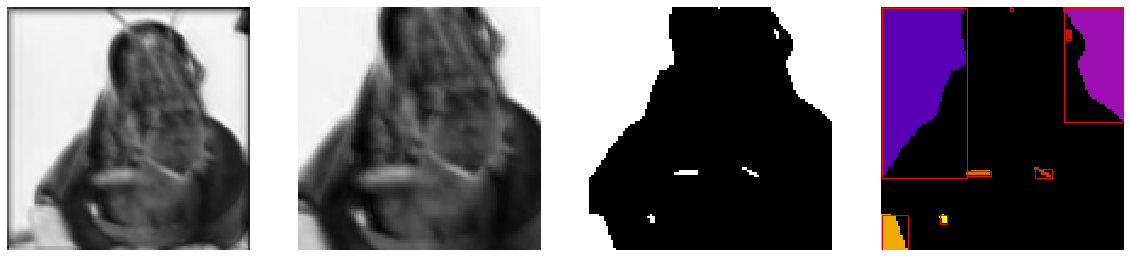

[ 47.33111032  77.2072468   64.76095819  66.88923155  50.02044309
  68.15829579  62.22429473  41.50174998  25.33317982  68.25437715
  68.72946158 105.41920418  91.11505433  16.23503228  54.23384635
  69.7250707  114.19170514  94.18777318  57.68231965  67.4583987
 110.09574014  91.90796007  25.27038231  67.41107407  45.1861497
  44.87788886  24.58099565  22.42039543]


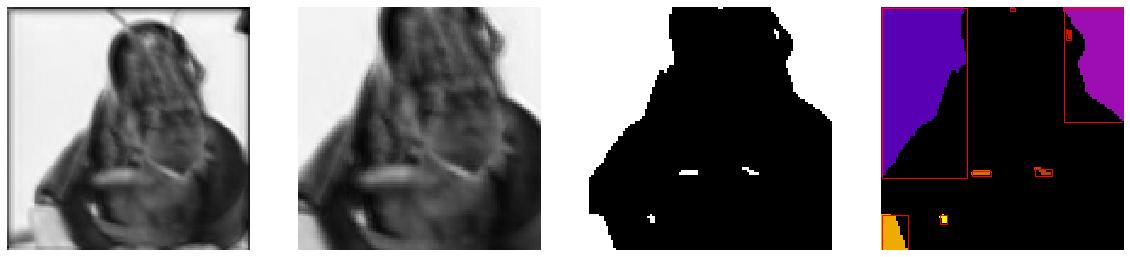

[ 77.21145102  64.74408861  67.22967817  50.18860534  68.18088417
  62.26298301  16.2583063   54.25768663  69.61248211 114.21015808
  94.18711601  57.80276524  67.38711347 110.10563173  91.90796007
  25.345916    67.62820007  45.35829155  45.03938076  24.67501137
  22.45533375]


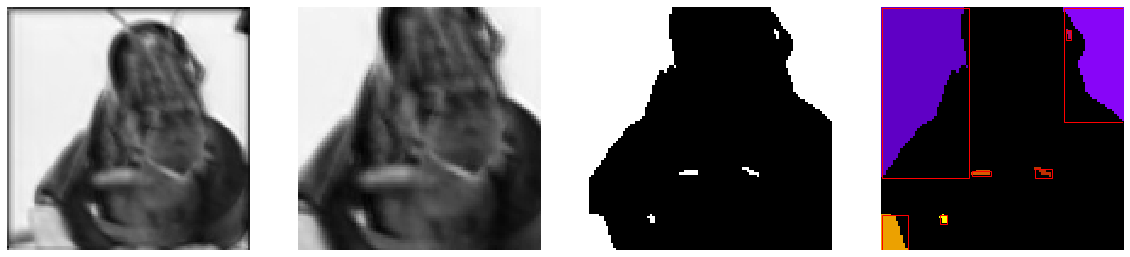

[ 47.77112281  77.19340573  64.83092301  67.03071966  49.61360333
  68.09653761  62.30375891  41.05168737  25.16197528  68.43530248
  68.99776378 105.60142194  91.30002124  15.92455774  54.46297723
  70.25410298 114.09230797  94.11164661  57.63638716  67.66256466
 109.85984029  91.67585143  26.00067607  67.20827441  44.94495287
  44.17032999  24.06485875  22.46608911]


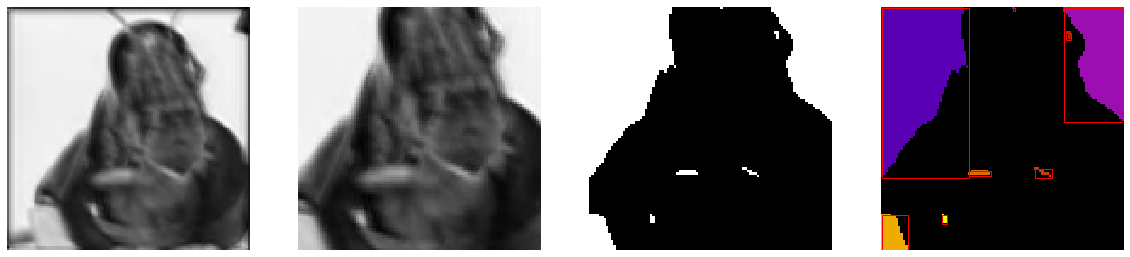

[ 47.35994473  77.22276106  64.7906355   67.60814968  49.89271815
  68.14502206  62.3418369   41.49413027  25.33317982  68.83865193
  68.8136637  105.41920418  91.14478838  16.22837316  54.44453025
  69.94199194 114.17651167  94.11362655  58.08485173  67.64079991
 110.09574014  91.88245374  26.06252698  67.6844405   45.30141458
  44.61772311  24.3322591   22.5670366 ]


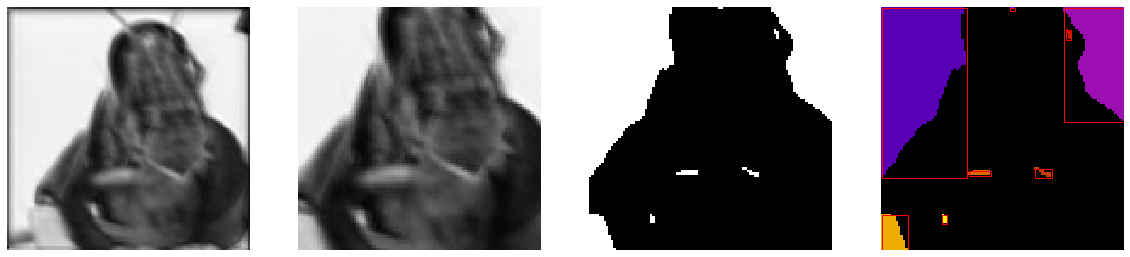

[ 47.32770793  77.21967955  64.82617609  67.4200498   49.61441788
  68.1629495   62.4207294   41.50517084  25.61493705  68.64289637
  69.14197626 105.40318574  91.20031203  15.93075846  54.34589079
  70.67314792 114.18130297  94.17946845  57.60111882  68.00939166
 109.9103659   91.7195891   26.78700126  67.64391531  45.31639458
  43.8284818   23.74514722  22.53141237]


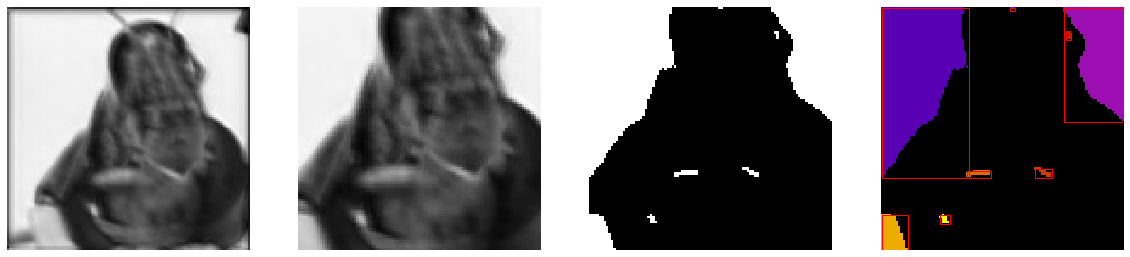

[ 47.31409248  77.1648428   64.72694024  67.33172936  49.58256711
  68.12357939  62.4961345   41.4957116   25.33317982  68.62339251
  69.16617195 105.40318574  91.23749914  16.22858706  54.32871224
  70.66903282 114.1686892   94.11308862  57.90544016  68.23656895
 110.07301566  91.90688902  26.75542696  67.63477079  45.18712483
  43.82513986  23.70277357  22.6789809 ]


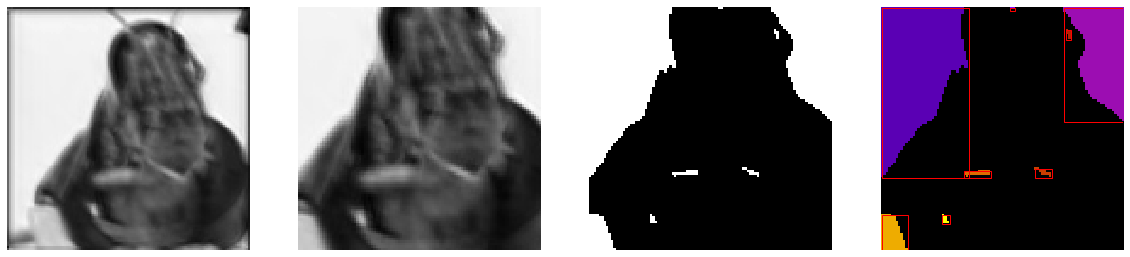

[ 77.2000123   64.8128946   66.99252429  49.90914973  68.21372842
  62.43463597  15.94771528  54.34370456  69.9697026  114.13864084
  94.14579771  57.51358535  67.45471732 109.90755107  91.7195891
  25.58550479  67.290548    45.01207828  44.54211945  24.34325647
  22.49401017]


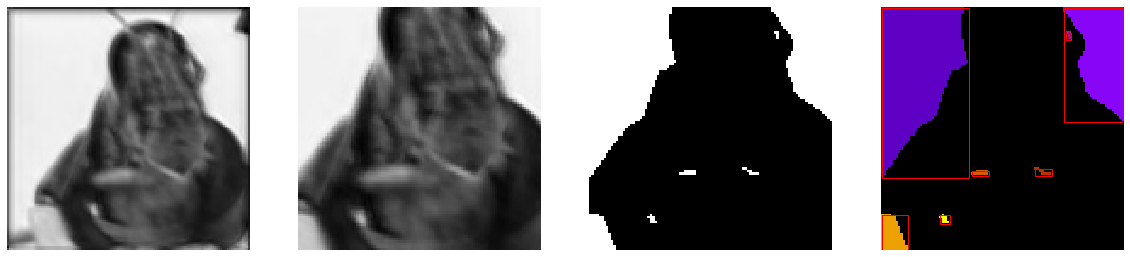

[ 77.21324738  64.73807062  67.38961325  49.57917774  68.17958569
  62.43058326  16.25534115  54.33716243  70.55331321 114.18724083
  94.18367919  57.90544016  68.09772839 110.07301566  91.92636076
  26.68681934  67.63477079  45.30845178  43.95019667  23.86992999
  22.53141237]


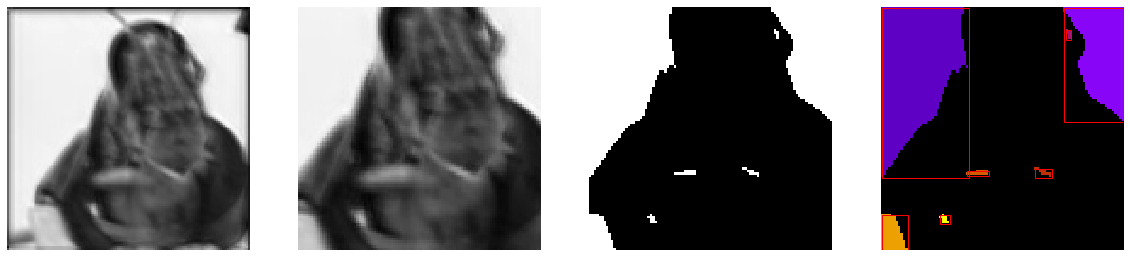

[ 77.21553537  64.83801507  67.21019285  49.65581799  68.12406307
  62.21449799  15.92186045  54.27148098  70.41801743 114.11230044
  94.19172331  57.4855803   67.79748301 109.85984029  91.7020481
  26.39302903  67.49940577  45.35829155  44.02545682  23.96388958
  22.31958429]


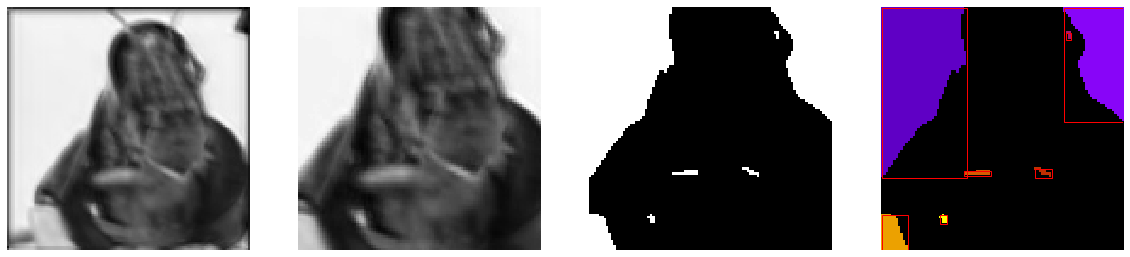

[ 47.66848715  77.11867121  64.73681518  66.99251526  49.7250743
  68.22016916  62.41470613  41.05620111  25.16197528  68.32693059
  68.92775568 105.65217546  91.35536366  15.92822726  54.33010991
  70.0884745  114.15378556  94.16344631  57.4980676   67.51728356
 109.90755107  91.7195891   25.85417337  67.3675585   45.08717551
  44.41519718  24.26492716  22.49401017]


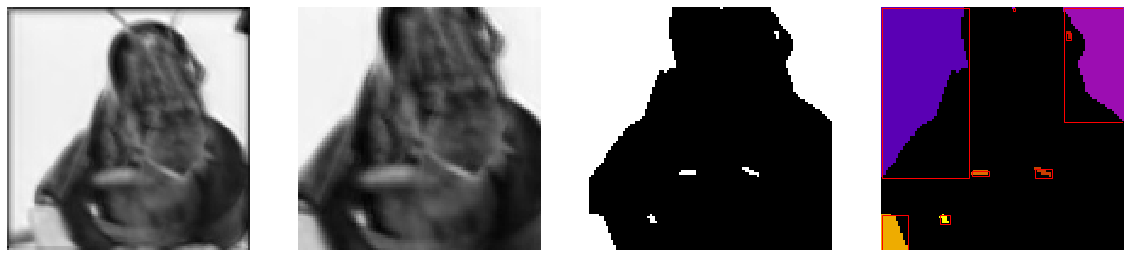

[ 47.33178276  77.21956524  64.81613516  66.55040586  49.48527775
  68.12877982  62.31513535  41.52677557  25.61493705  68.21937154
  68.9814992  105.40318574  91.14478838  15.95262454  54.47779312
  70.5187521  114.18476201  94.14583548  57.49012781  67.84431917
 109.9103659   91.67585143  25.86938041  66.96686361  44.6597111
  43.97478469  23.86728749  22.5335874 ]


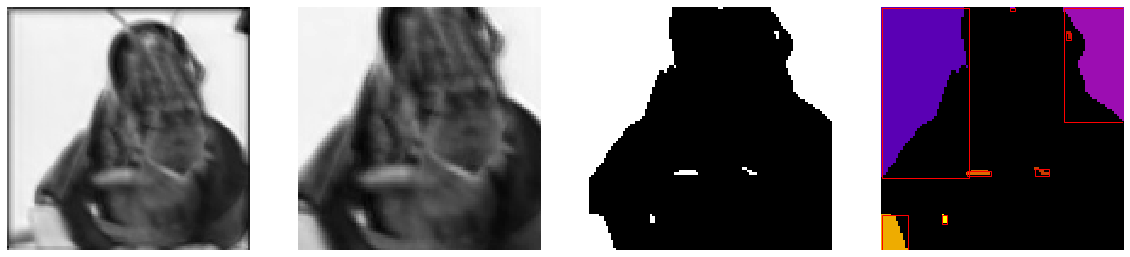

[ 47.76511946  77.26892325  64.84553107  67.41569655  49.64014641
  68.19770857  62.36360805  41.09064302  25.16197528  68.5311608
  69.00225886 105.65217546  91.30002124  15.96159208  54.34261853
  70.33656165 114.18571436  94.15794388  57.5877157   67.68692682
 109.90755107  91.67585143  26.45601288  67.60344486  45.29569065
  44.1709453   24.03679493  22.49634079]


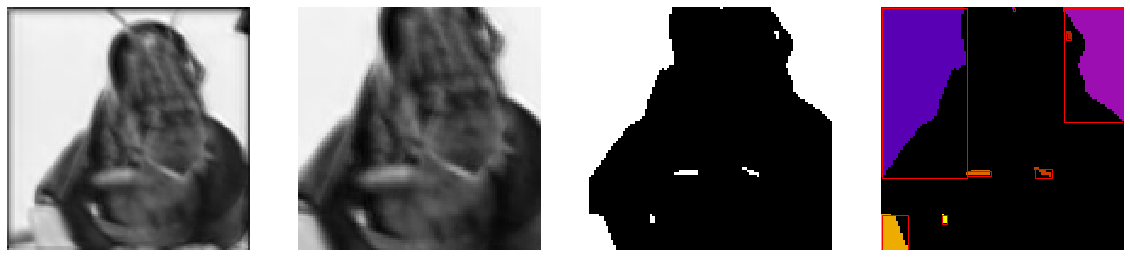

[ 77.17348292  64.7779209   67.17377089  49.93307293  68.11763562
  62.53442204  15.9514143   54.25768663  69.99650856 114.14768893
  94.10833259  57.4855803   67.47902184 109.88448605  91.69940703
  25.82074251  67.56167606  45.12745094  44.54692888  24.29075025
  22.68169734]


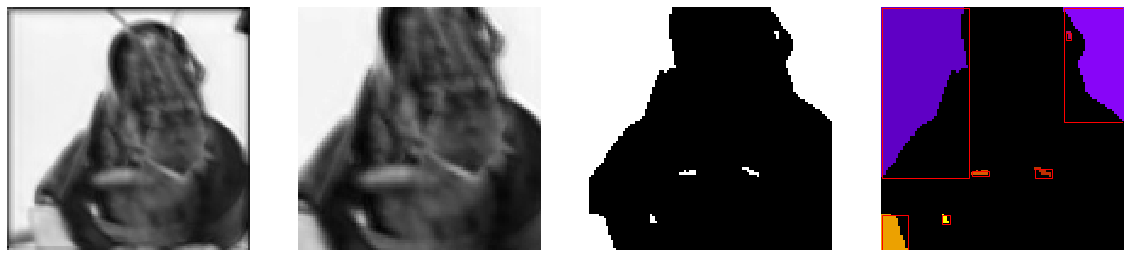

[ 47.76663282  77.24965233  64.82457413  67.172887    50.45166081
  48.46283406  68.09457734  62.49461586  41.08914986  25.16197528
  68.38303642  68.7459817   70.09279564 105.60142194  91.39149988
  15.95898436  54.30794367  69.27748644  72.8054562  114.16119747
  94.15948675  57.4855803   66.8915914   69.6966642  109.85984029
  91.69940703  24.77488898  29.28176032  67.49940577  45.12745094
   4.5177428   45.38558097  24.97080796  41.48550845  22.0376099
  22.61137382]


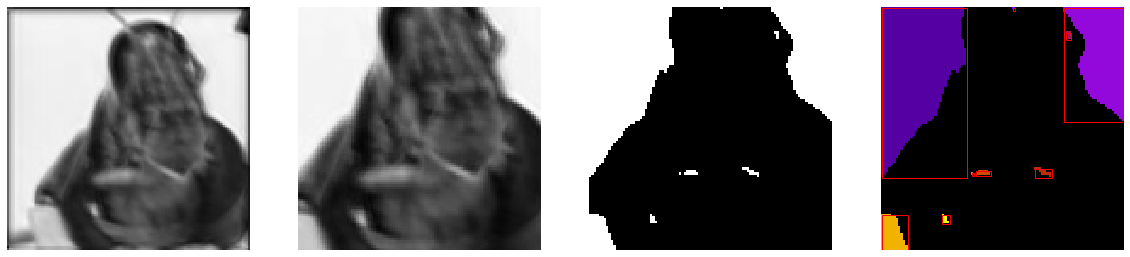

[ 77.16387461  64.74706338  67.16134058  50.13204687  68.18320854
  62.41449064  15.96348749  54.27404868  69.63220007 114.18734018
  94.18222207  57.4855803   67.17030214 109.9103659   91.7195891
  25.345916    67.56517026  45.24815658  44.98893788  24.67067162
  22.53141237]


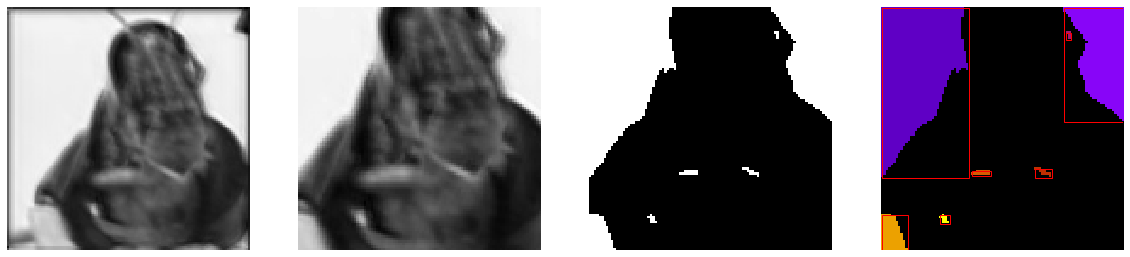

[ 47.68800265  77.18142322  64.75380802  66.52809842  49.9863553
  68.1582157   62.5331526   41.09779667  25.16197528  68.13267369
  68.82409139 105.61697717  91.39149988  15.96860855  54.49020811
  69.76000129 114.17144328  94.14290284  57.49012781  67.24245104
 109.88185512  91.69940703  24.84116436  66.93220437  44.55417621
  44.81674291  24.54306023  22.64381504]


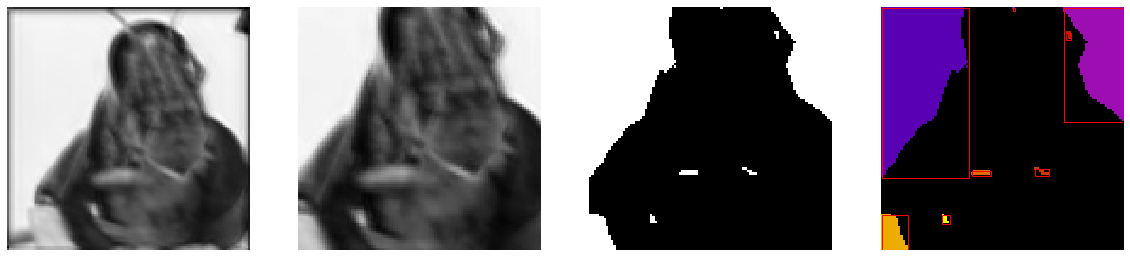

[ 47.31006293  77.21566431  64.80138184  67.18892058  49.73899536
  68.10563432  62.53429047  41.53392001  25.61493705  68.47453831
  68.8296177  105.35209412  91.23749914  15.95961757  54.27827165
  70.11121021 114.14469619  94.13078855  57.4855803   67.51728356
 109.86225538  91.69940703  26.04331379  67.53008832  45.12745094
  44.39073291  24.2328334   22.64866122]


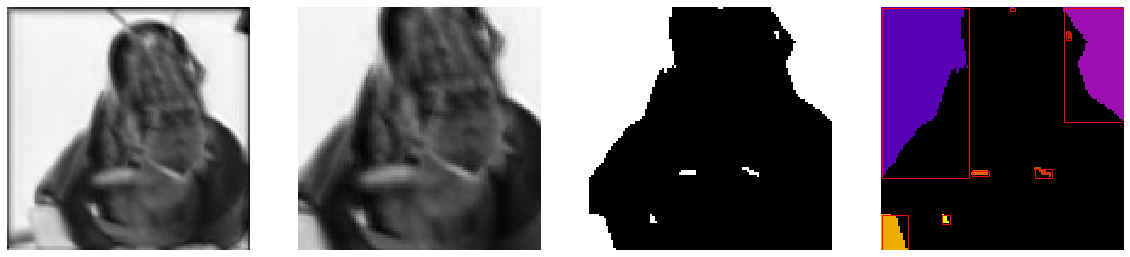

[ 47.75886436  77.20742474  64.80766078  67.14275895  50.89888168
  68.07747297  62.3404208   41.08725583  25.16197528  68.38303642
  68.47262227 105.60142194  91.35536366  15.95900631  54.26977461
  68.46437131 114.12515572  94.17673791  57.4855803   66.28442502
 109.85984029  91.7195891   23.77381364  67.49940577  45.24815658
  46.27363206  25.739555    22.46387915]


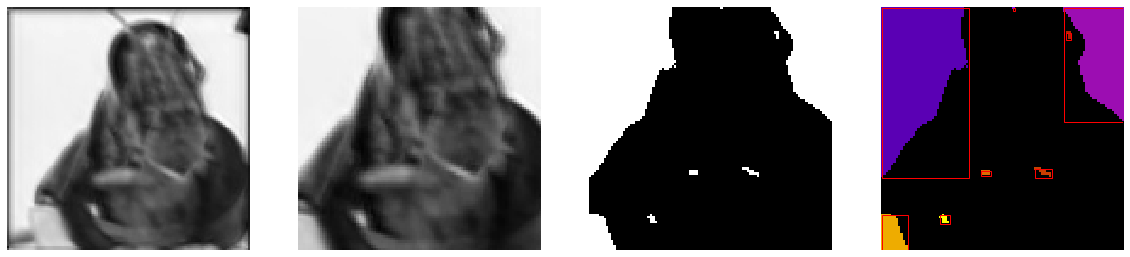

[ 47.71754227  77.22370838  64.77733863  67.15423074  49.7907382
  68.14136308  62.43160097  41.11883641  25.16197528  68.38303642
  69.00871775 105.64000697  91.32798038  15.98921574  54.29596115
  70.18449295 114.21805148  94.11969091  57.4855803   67.57969832
 109.9103659   91.65110474  26.02511154  67.56517026  45.11745919
  44.39956728  24.13095781  22.67506589]


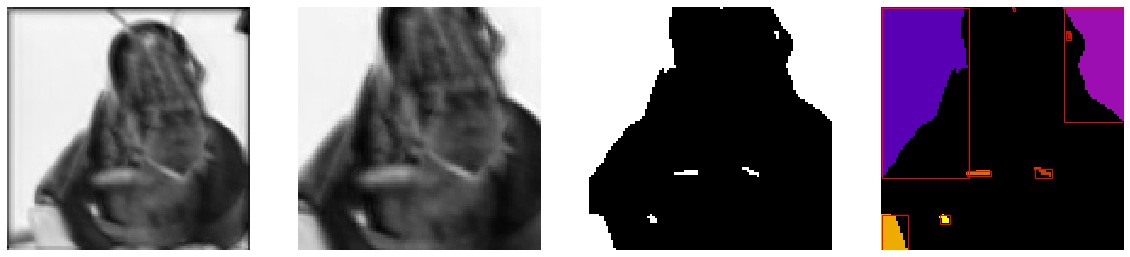

[ 47.7380456   77.23682871  64.81015108  67.17588425  50.01442334
  47.72219044  68.14233869  62.46236492  41.09046463  25.16197528
  68.31639627  68.82409139  71.01564773 105.60142194  91.32798038
  15.96086642  54.21922031  69.76563367  74.75008718 114.15108892
  94.1118444   57.40910207  67.24245104  71.32213697 109.85984029
  91.65110474  25.56883954  31.65362889  67.55229748  45.17355421
   6.11918658  44.78920472  24.4994331   39.43642985  20.5723655
  22.6074993 ]


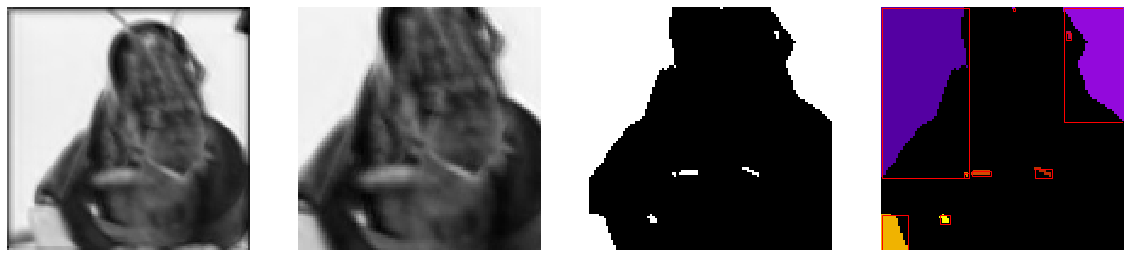

[ 77.25576515  64.79683693  67.30738071  49.72486071  68.14636539
  62.41056846  16.0001709   54.26170756  70.25590886 114.16427692
  94.21269756  57.48934684  67.62036878 109.85984029  91.7195891
  26.28393341  67.60680195  45.35131043  44.25195528  24.15660191
  22.46387915]


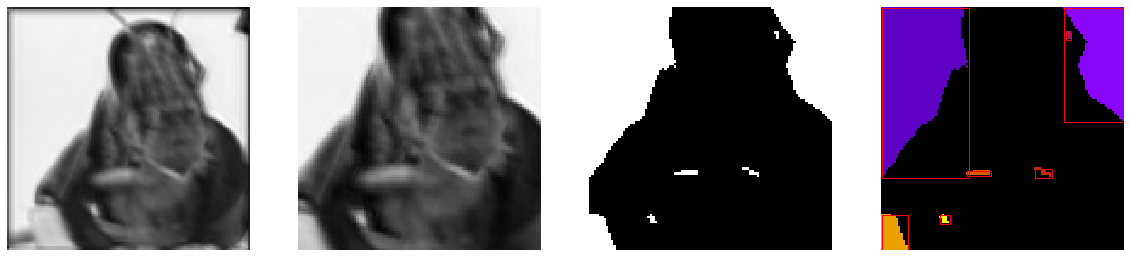

[ 77.16013217  64.73383252  66.79731332  49.93212349  68.12988044
  62.42186791  15.95898436  54.27651793  69.91801274 114.16119747
  94.12246403  57.36623571  67.37020855 109.85984029  91.65110474
  25.40492078  67.31330927  44.94719124  44.64157969  24.36472861
  22.6074993 ]


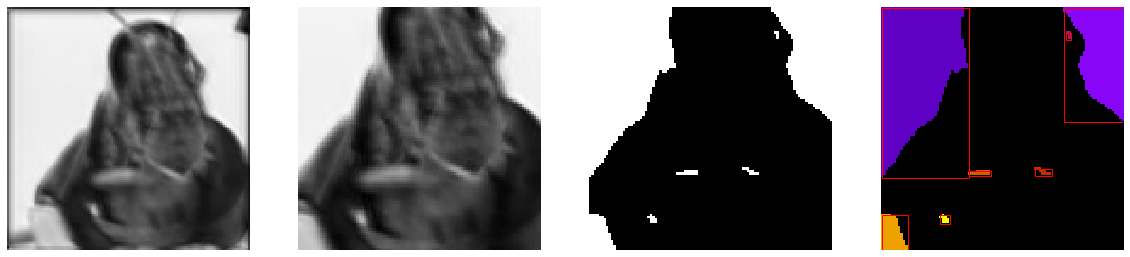

[ 77.26817341  64.83801507  67.21019285  49.73090774  68.09045974
  62.53105026  15.95898436  54.30794367  70.25545737 114.17246579
  94.15948675  57.4855803   67.62036878 109.86225538  91.69940703
  26.15698313  67.53008832  45.12745094  44.2694512   24.12501008
  22.64866122]


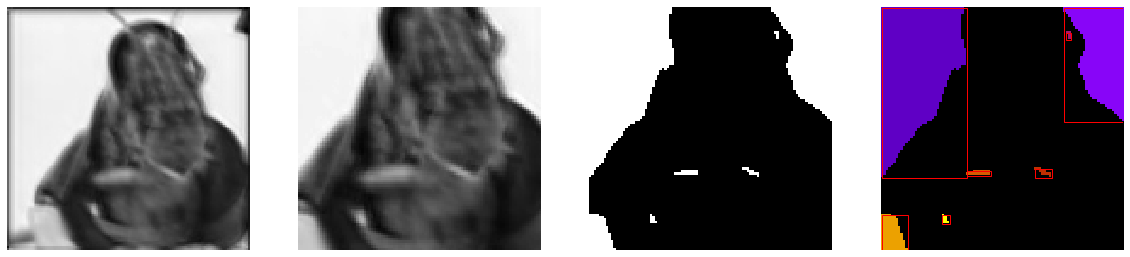

[ 77.25989824  64.986575    67.20185651  50.29687281  68.15692314
  62.47415082  15.65900115  54.29423806  69.42519504 114.16427692
  94.12123291  57.28607348  66.90318007 109.83932103  91.58384137
  25.04336793  67.49940577  45.11745919  45.19696114  24.80580196
  22.6074993 ]


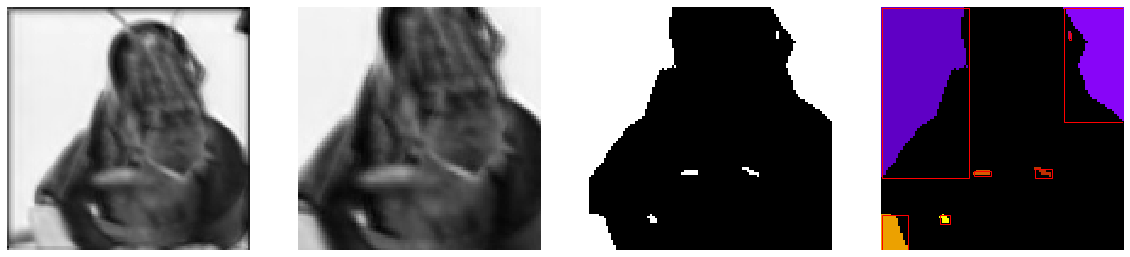

[ 77.22502734  64.94193852  67.17313019  50.14312094  68.11945729
  62.42323184  15.67250058  54.29069556  69.66453274 114.1934094
  94.213239    57.28607348  67.09302862 109.8513991   91.65286091
  25.345916    67.5599438   45.24815658  44.96772113  24.67067162
  22.53504303]


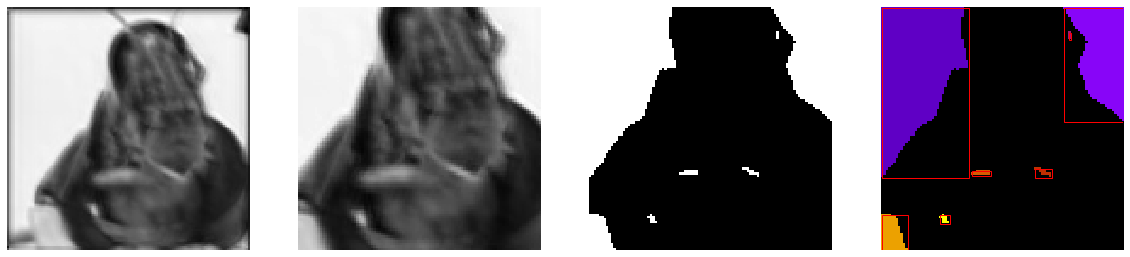

[ 47.26157254  77.15951276  64.74555593  22.2992733   66.82354572
  49.95881545  68.14806898  62.56689058  41.53755968  25.61493705
  31.34086789  68.25437715  68.81983726 105.3648377   91.20416996
  15.96348749  55.05020501  54.24263837  69.88679103 114.13093859
  94.03253168  43.51005631  57.36623571  67.37020855 109.85984029
  91.62585792  50.88428048  41.85355421  74.25380837  61.74099624
  25.40492078  67.31330927  44.82663588  44.64157969  24.3261075
  22.75492385]


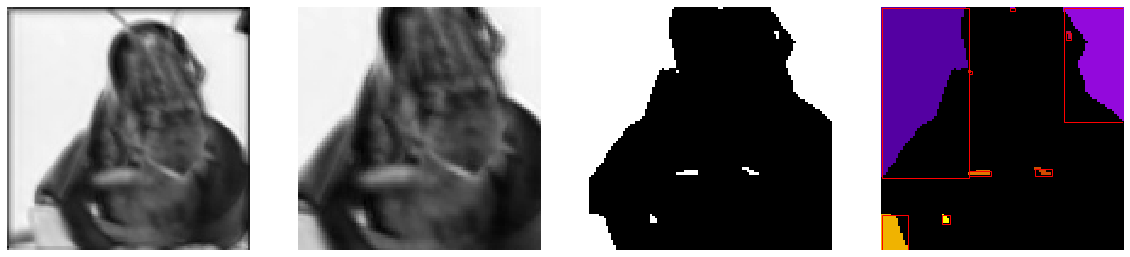

[ 47.2966516   77.22445797  64.78441447  67.17229821  50.26739925
  68.13818786  62.57018461  41.55244008  25.61493705  68.47453831
  68.64384758 105.3648377   91.20416996  15.976955    54.29897611
  69.42231196 114.15972248  94.06074032  57.4855803   66.98167748
 109.85984029  91.62585792  25.04336793  67.49940577  44.99594127
  45.19696114  24.76356161  22.75492385]


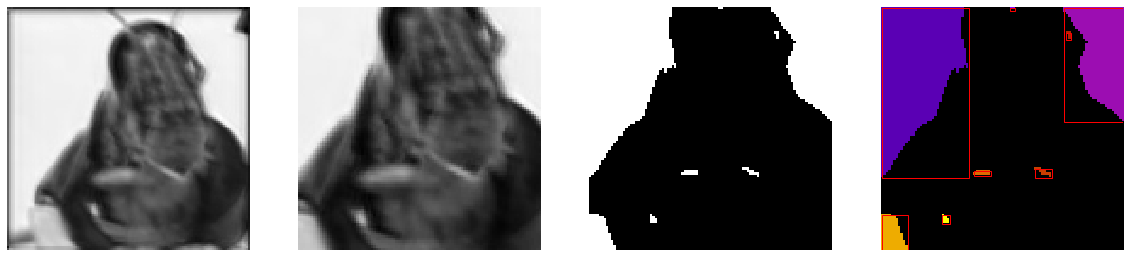

[ 47.24334057  77.18624831  64.72836502  67.13861069  49.80646107
  68.12526708  62.57357346  41.57543322  25.61493705  68.47453831
  68.82555507 105.32520739  91.20416996  16.0001709   54.29423806
  70.05323252 114.12463725  94.06290465  57.4855803   67.45962334
 109.81955341  91.62585792  25.89934837  67.46407448  44.99594127
  44.43916452  24.21958307  22.72221469]


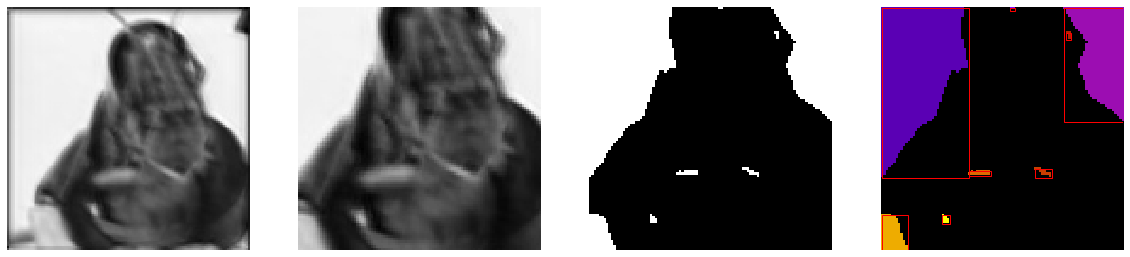

[ 47.67360727  77.1835311   64.91547932  67.11835951  49.66658262
  68.14030122  62.42647166  41.14140038  25.49509757  68.38303642
  68.99919763 105.61697717  91.32798038  15.67141172  54.27728575
  70.2437266  114.17846689  94.10840878  57.28607348  67.54654937
 109.8614183   91.58384137  26.15698313  67.53047561  45.11745919
  44.27935792  24.08015738  22.63990675]


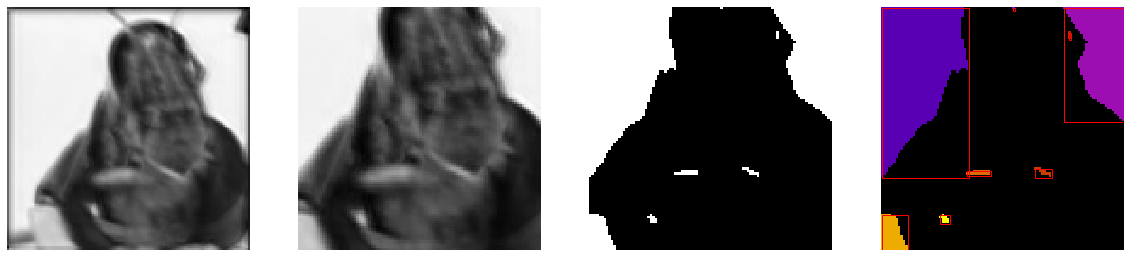

[ 77.22742053  64.78705459  66.52741381  49.97402458  68.0543366
  62.56691748  15.99011713  54.31266419  69.90204017 114.08904792
  94.04691688  57.33151644  67.37020855 109.79427675  91.62585792
  25.07384649  67.00497483  44.57231605  44.58891127  24.3261075
  22.72501174]


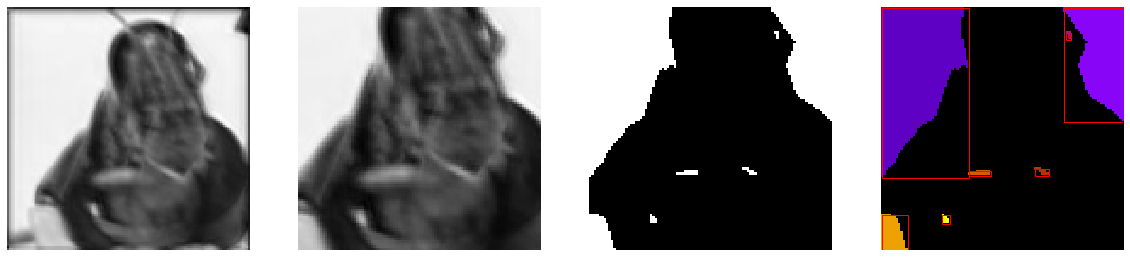

[ 77.25208623  64.76744422  22.32198434  67.16286268  49.47357246
  68.14570425  62.57218351  16.01636088  55.1205328   54.31751331
  70.77628349 114.19253673  94.09028111  43.51005631  57.4855803
  68.02284171 109.85984029  91.62585792  51.18472461  41.83310065
  74.25380837  61.74099624  26.74957655  67.49940577  44.99594127
  43.7129823   23.61867838  22.75492385]


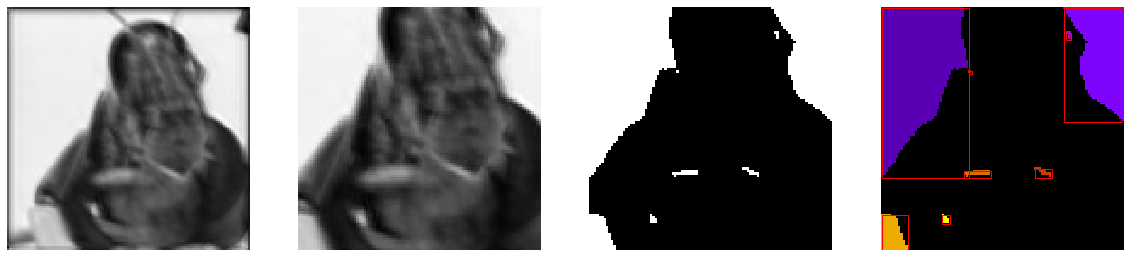

[ 77.19468324  64.91311435  66.82726482  49.85255647  68.17420309
  62.46663275  15.65476471  54.28506556  70.02821991 114.18337662
  94.14138549  57.16826042  67.35081894 109.83932103  91.58384137
  25.56668364  67.31330927  44.94719124  44.52921049  24.2947075
  22.6074993 ]


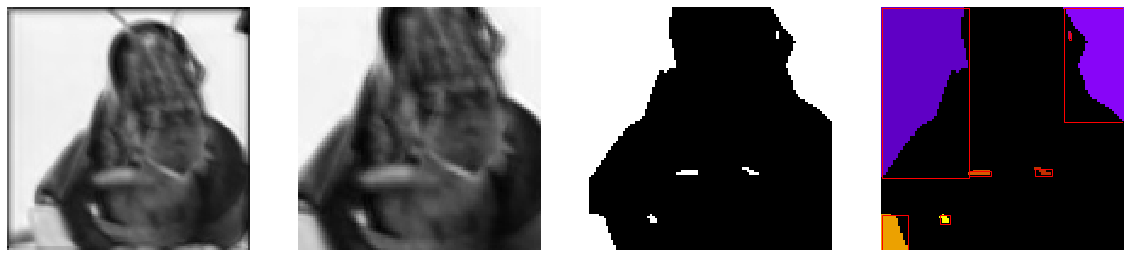

[ 77.23427846  64.7304328   67.26867438  50.08238761  68.09417919
  62.5409219   16.0337854   54.45892332  69.71138594 114.17382607
  94.10996503  57.64344694  67.17030214 109.81955341  91.62585792
  25.40507926  67.45516502  44.97598811  44.8900476   24.55016948
  22.72221469]


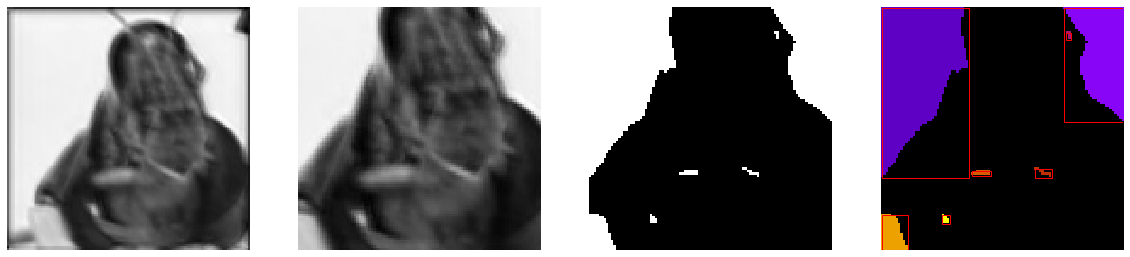

[ 47.71849636  77.25429777  64.78428503  67.17194733  50.12962603
  47.55138567  68.13791403  62.56984425  41.12206075  25.16197528
  68.38303642  68.82412516  70.60453243 105.60142194  91.35739072
  15.9907232   54.33084869  69.69583652  74.32330206 114.19515557
  94.09577865  57.4855803   67.17030214  70.8563688  109.85984029
  91.62585792  25.345916    31.28118279  67.49940577  44.99594127
   5.94404178  44.92865581  24.55016948  39.90491511  21.01997874
  22.75492385]


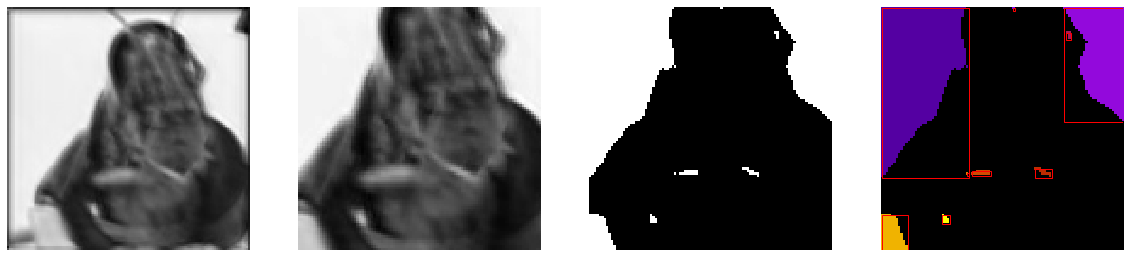

[ 47.25121041  77.22566526  64.73272016  67.13246449  50.10322624
  68.1131733   62.56214185  41.60632668  25.61493705  68.47453831
  68.73091572 105.32520739  91.20416996  16.02993134  54.31399717
  69.69227185 114.15485189  94.09081608  57.4855803   67.17030214
 109.81955341  91.62585792  25.345916    67.46407448  44.99594127
  44.8900476   24.55016948  22.72221469]


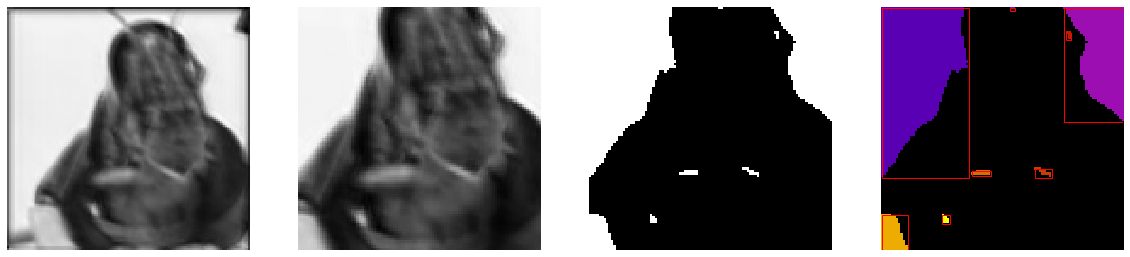

[ 77.2319759   64.77061658  67.17607303  49.71829799  68.11139295
  62.58640274  16.00725679  54.28697476  70.25126225 114.09096223
  94.05790098  57.4855803   67.62036878 109.79245019  91.62585792
  26.15698313  67.43100823  44.99594127  44.1822475   24.04468923
  22.68867729]


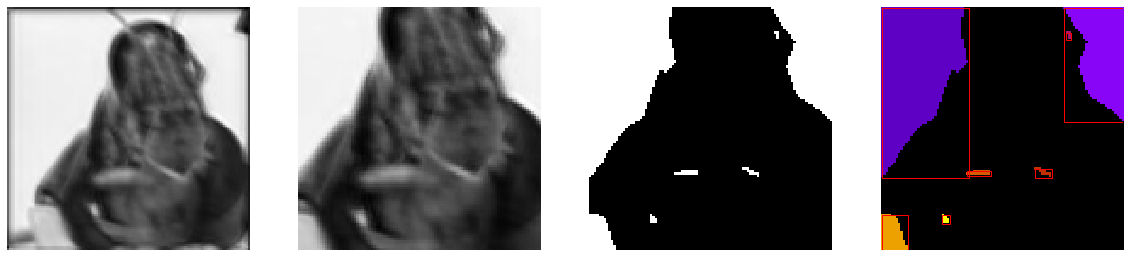

[ 77.30003277  64.81612967  67.13798407  49.66439868  68.06245961
  62.50020991  16.02594495  54.32019142  70.66501702 114.19878613
  94.09568111  57.4855803   67.97061865 109.85984029  91.62585792
  26.47797775  67.49940577  44.99594127  43.87028157  23.68561578
  22.75492385]


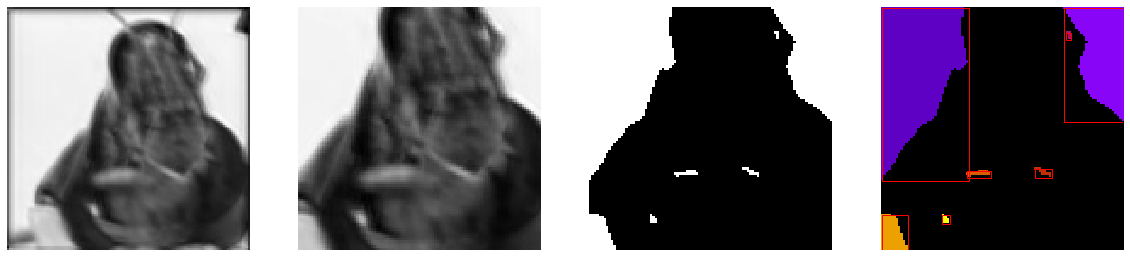

[ 77.21151158  64.90351988  66.81140812  49.79011858  68.1311496
  62.57558041  15.71394699  54.24606228  70.18790836 114.12967672
  94.06210048  57.16826042  67.50520813 109.79904058  91.55784787
  25.75535139  67.27790211  44.82663588  44.30084014  24.09445229
  22.72221469]


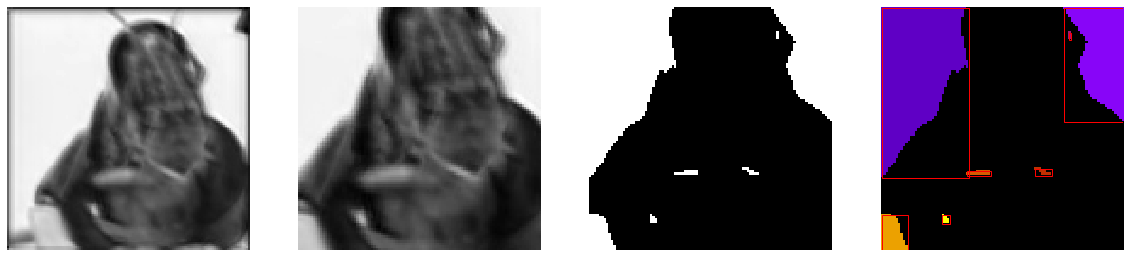

[ 46.89176982  77.28622222  64.80456301  66.87197856  49.82596456
  68.12838245  62.39891564  42.04057733  26.06961833  68.34771393
  68.81644516 105.10797679  90.8665505   16.01745771  54.27802959
  70.20646666 114.15490676  93.93033896  57.36623571  67.57969832
 109.8321983   91.45657439  25.75535139  67.27972045  44.72359556
  44.30796665  23.93027633  22.79310387]


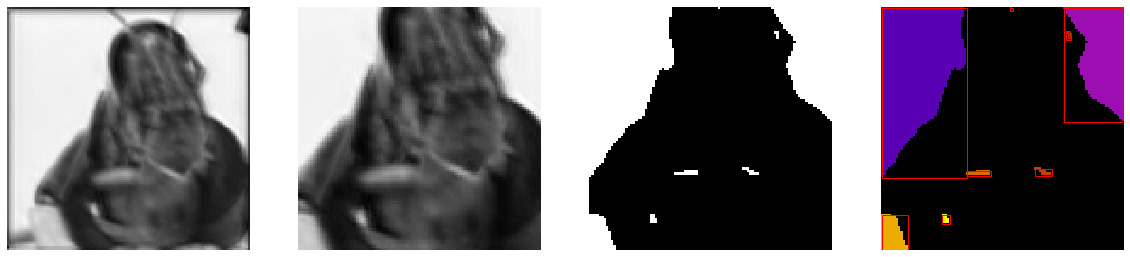

[ 47.65849643  77.23480471  64.89829092  67.10505857  49.75935216
  68.10436992  62.54499645  41.1959579   25.49509757  68.38303642
  69.00871775 105.56176065  91.35739072  15.72406728  54.31928359
  70.23194616 114.17348068  94.10619642  57.28607348  67.50520813
 109.79904058  91.55784787  26.02511154  67.46407448  44.99594127
  44.30084014  24.09445229  22.72221469]


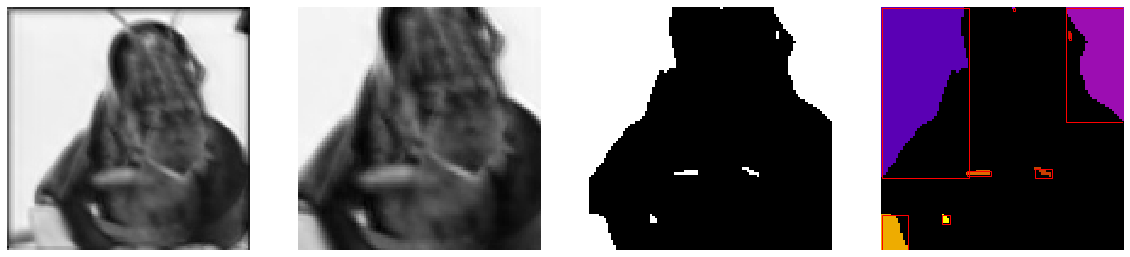

[ 77.23615353  64.75596092  67.12965897  49.77013135  68.11896585
  62.7898146   16.01236247  54.32370482  70.21884207 114.19682485
  94.19946792  57.4855803   67.57969832 109.85984029  91.76822026
  26.02511154  67.49940577  45.0120995   44.3395364   24.22582558
  22.78741235]


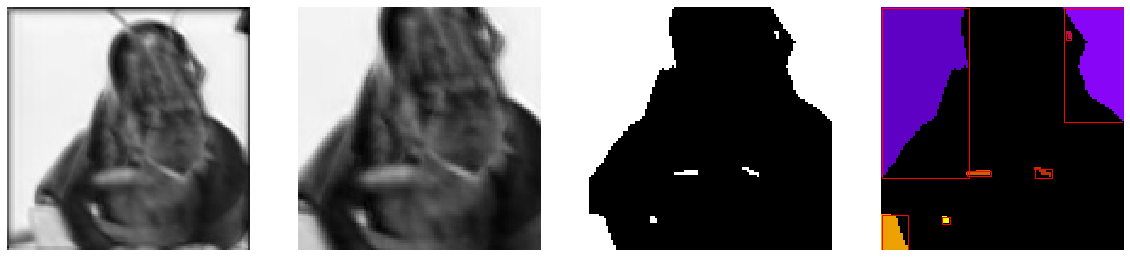

[ 77.26939129  64.95646649  67.13578109  50.07125215  68.07663244
  62.53602411  15.68324957  54.34166073  69.61605966 114.17869202
  94.11603759  57.28607348  66.99440275 109.79904058  91.55784787
  25.27374916  67.46407448  44.99594127  44.98932442  24.65045764
  22.72221469]


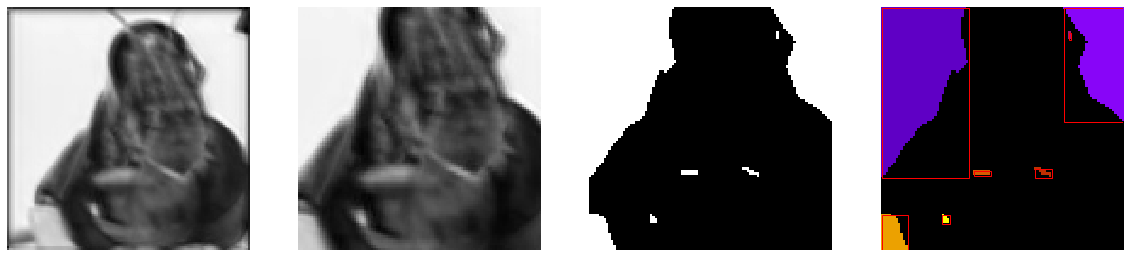

[ 47.6413568   77.21200799  64.70326194  67.30194684  49.78446443
  68.12275653  62.45335167  41.16526904  25.16197528  68.5311608
  69.00871775 105.5399156   91.32798038  16.0337854   54.3893929
  70.23438952 114.14425272  94.16833989  57.5877157   67.57969832
 109.79245019  91.65110474  26.15096796  67.50059475  45.17742799
  44.26982477  24.13095781  22.54112588]


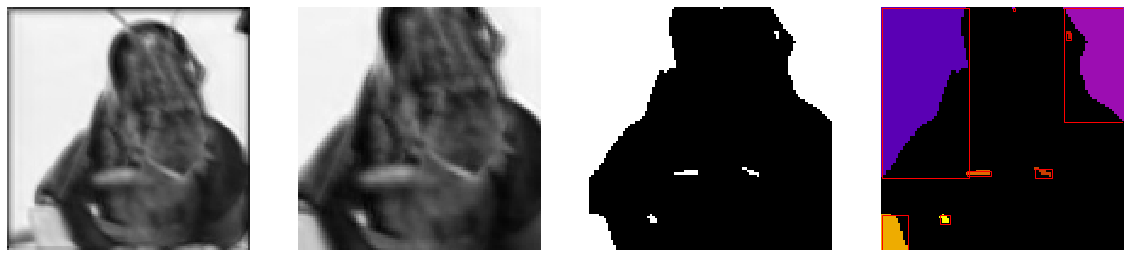

[ 77.26286464  64.94908517  67.11857688  49.6525435   68.05250474
  62.52013936  15.69285176  54.33252535  70.30388875 114.14425272
  94.10996503  57.28607348  67.54654937 109.77187372  91.55784787
  26.15698313  67.43100823  44.99594127  44.1822475   24.04468923
  22.68867729]


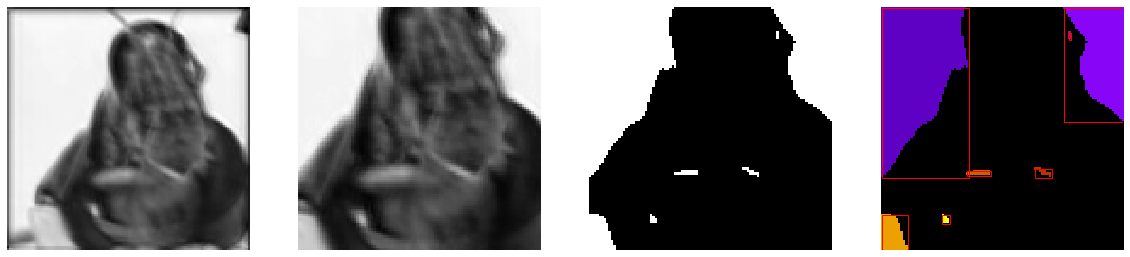

[ 47.64341182  77.21826736  64.89562334  66.213888    49.79412177
  68.14053682  62.83325158  41.16526904  25.49509757  67.82691056
  69.00871775 105.56176065  91.55206852  15.69285176  54.34823494
  70.23438952 114.17382607  94.21424772  57.04312726  67.50520813
 109.79904058  91.69940703  25.19027717  66.84473455  44.44402149
  44.30084014  24.22582558  22.75496785]


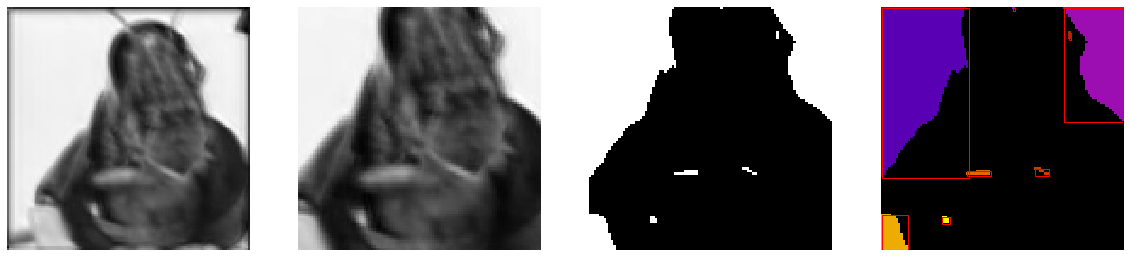

[ 77.19738876  64.89053012  66.81328514  49.69638691  68.14774755
  62.58874291  15.67466929  54.29945051  70.2959602  114.16489233
  94.10273295  57.16826042  67.54654937 109.79904058  91.55784787
  25.88695748  67.27790211  44.82663588  44.21323195  24.04468923
  22.72221469]


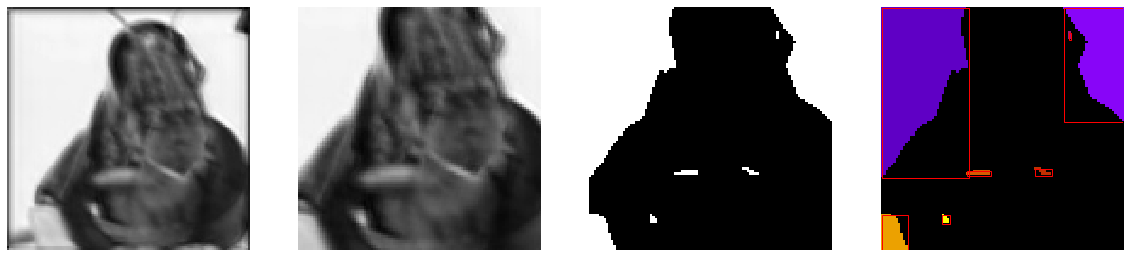

[ 77.23031849  64.73620313  22.29077331  67.14045929  49.58418163
  68.10704342  62.56945108  16.02594495  55.13009927  54.32019142
  70.78565744 114.12957452  94.09568111  43.51005631  57.4855803
  68.05486394 109.79245019  91.62585792  51.18472461  41.93355267
  74.19391671  61.74099624  26.66639931  67.43100823  44.99594127
  43.65865441  23.59228007  22.68867729]


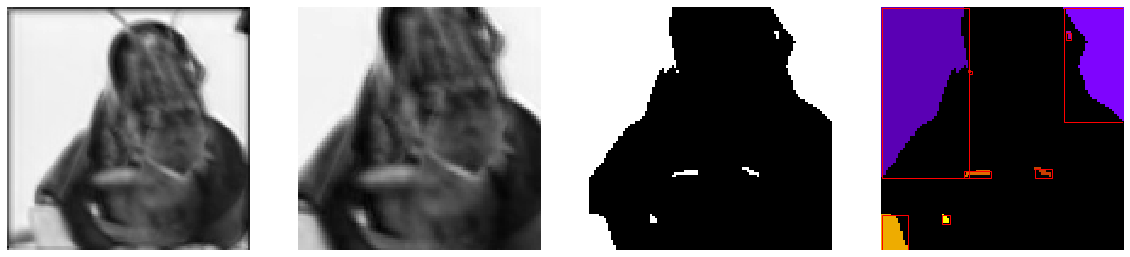

In [85]:
#bounding box drawing
top,bottom,left,right = 20,120,20,120
plt.close()
for i in range(3*30,4*30):#nframes):
    x= gen2.__getitem__(i)
    result = model.predict(x)
    for batch_number in range(batch_size):
        tracked = result[batch_number].squeeze()
        blurred = tracked[20:120,20:120] #ignoring edge cases which were producing noisy results.
        blurred = tracked[top:bottom,left:right] #ignoring edge cases which were producing noisy results.
        binary = blurred > threshold_isodata(blurred) #changed from Otsu
        labels = measure.label(binary,connectivity = 2)
        
        props = measure.regionprops(labels)
        
        if len(props)==1:
            print('splitting')
            split = props[0].centroid[1]
            binary[:,np.round(split).astype(int)] = 0
            labels = measure.label(binary,connectivity = 2)
            props = measure.regionprops(labels)
        plots = {'Tracked': tracked, 'Blurred': blurred, 
                 'Binary': binary, 'Labels': labels}
        fig, ax = plt.subplots(1, len(plots),figsize=(20,10))

        for n, (title, img) in enumerate(plots.items()):
            cmap = plt.cm.gnuplot if n == len(plots) - 1 else plt.cm.gray
            ax[n].imshow(img, cmap=cmap)
            ax[n].axis('off')




        props = measure.regionprops(labels)
        if len(props)>1:
            #find the largest two areas, then find pdist between them
            coords = []
            for ii,prop in enumerate(props):
                coords.append(prop.centroid)
            coords = np.array(coords)
            print(scipy.spatial.distance.pdist(coords))
#             final_coords.append(scipy.spatial.distance.pdist(coords[0:2]))

        for prop in props:
            rect = prop.bbox
            p = matplotlib.patches.Rectangle((rect[1],rect[0]), rect[3]-rect[1], rect[2]-rect[0],alpha = 1, fill = False, edgecolor = 'red')
            ax[n].add_patch(p)

        plt.show(fig)
        

# Trying all threshold options on some frames

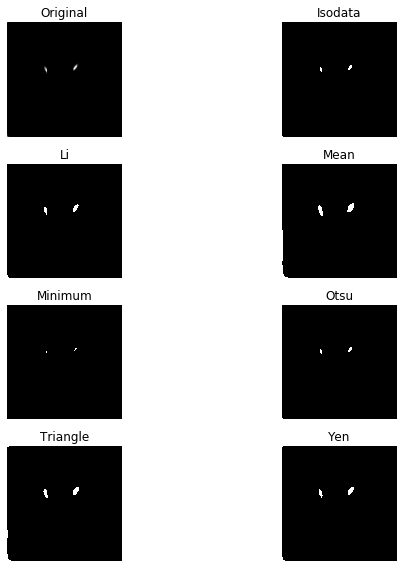

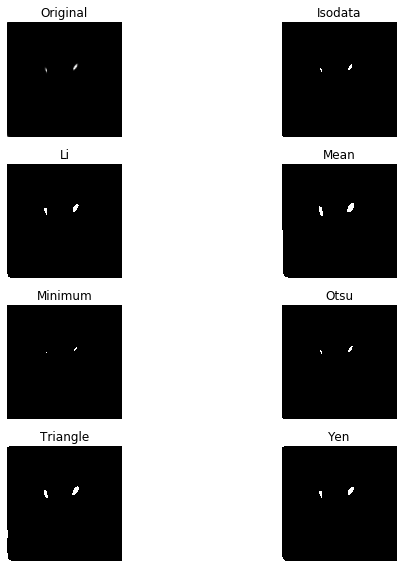

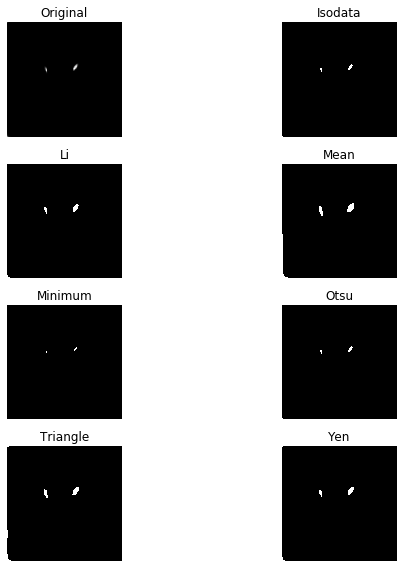

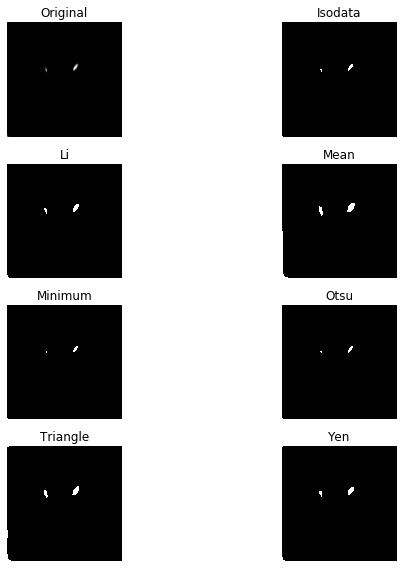

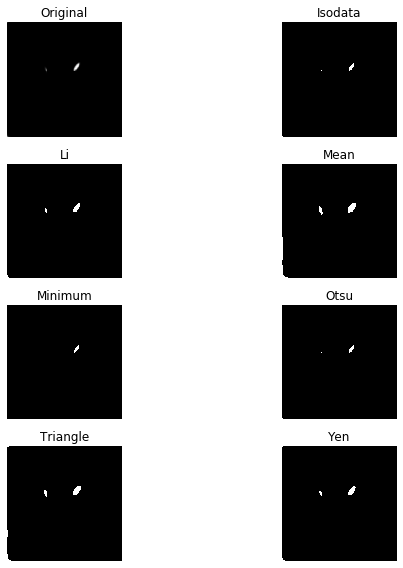

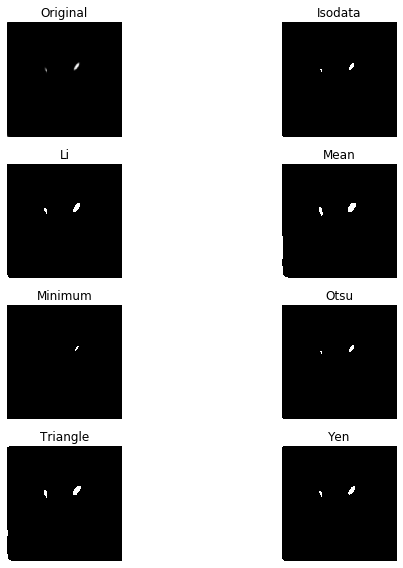

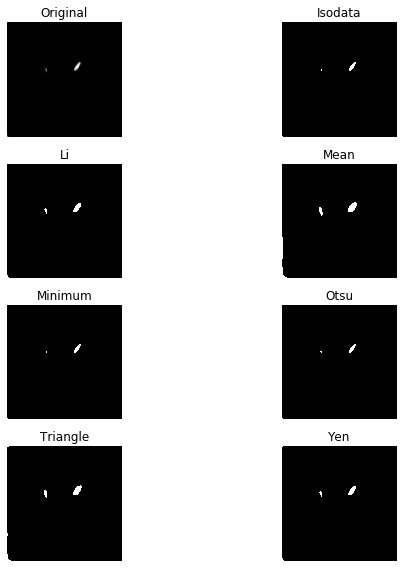

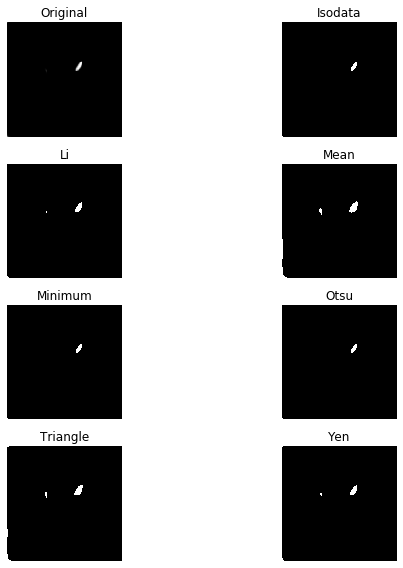

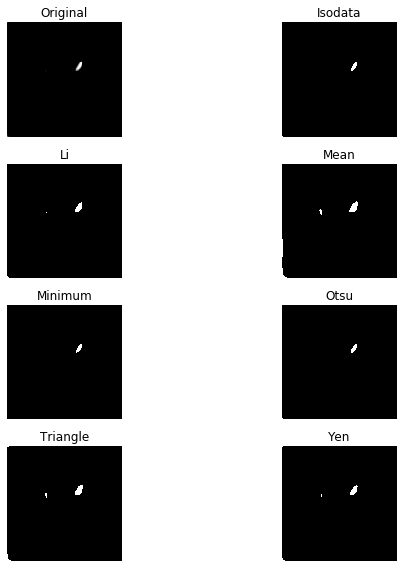

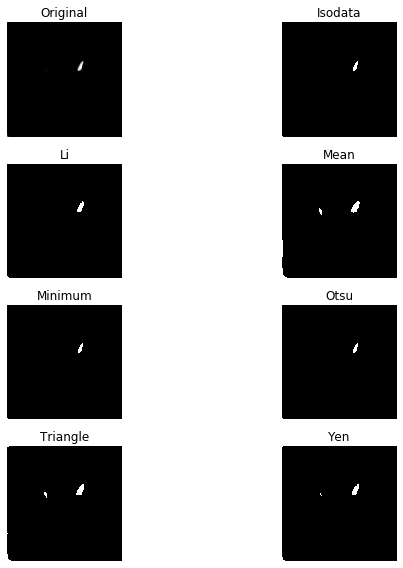

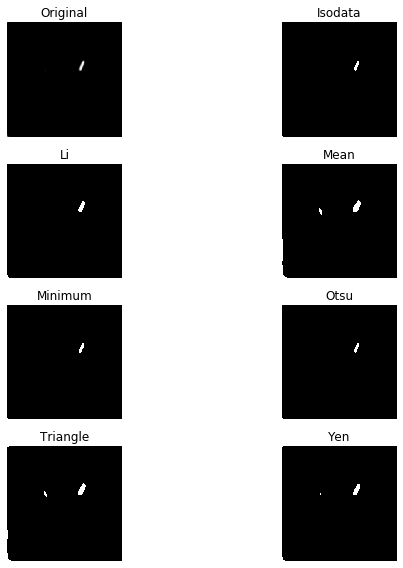

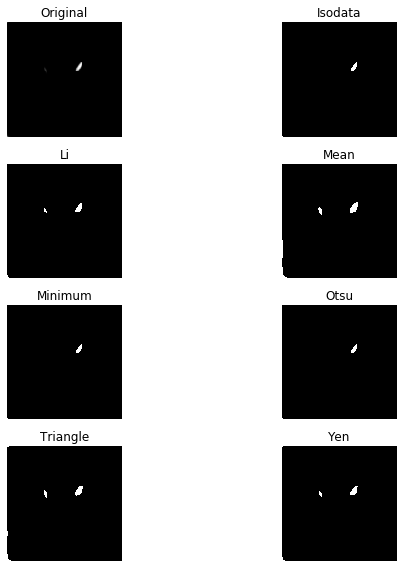

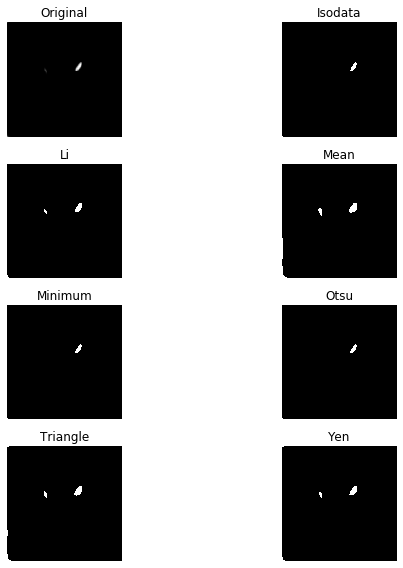

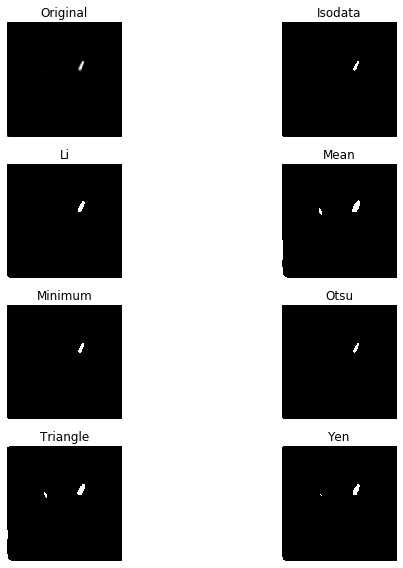

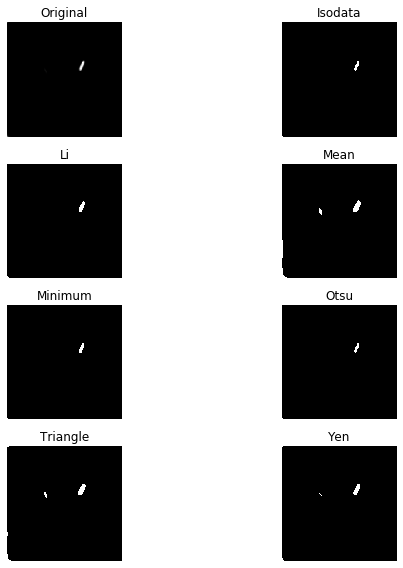

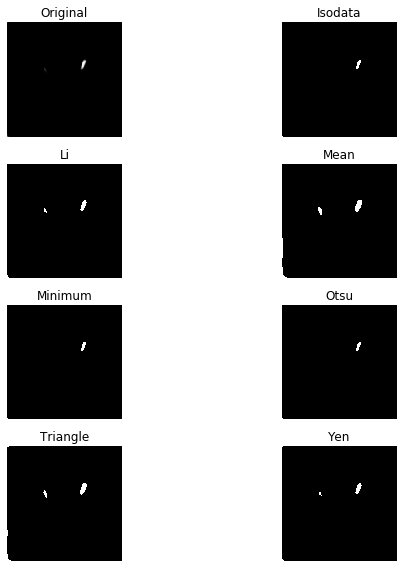

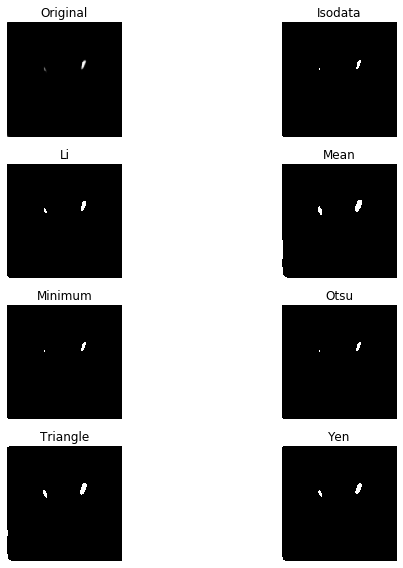

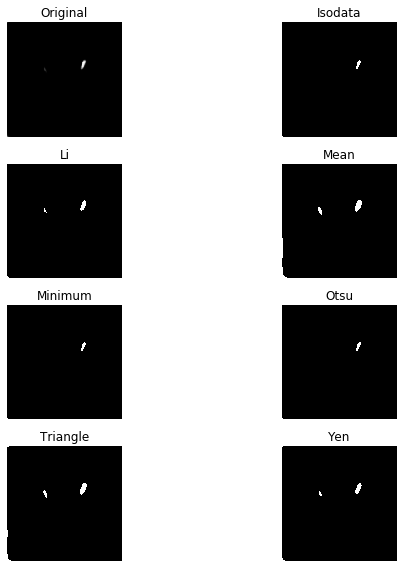

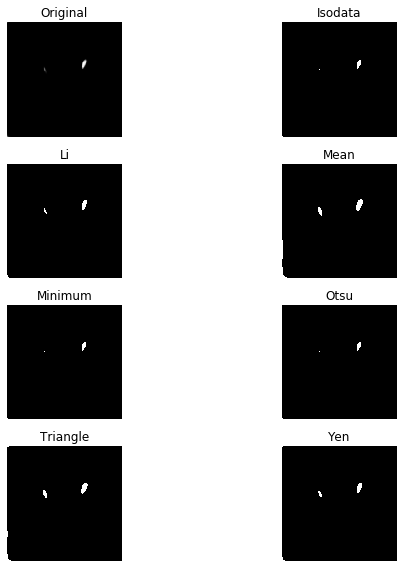

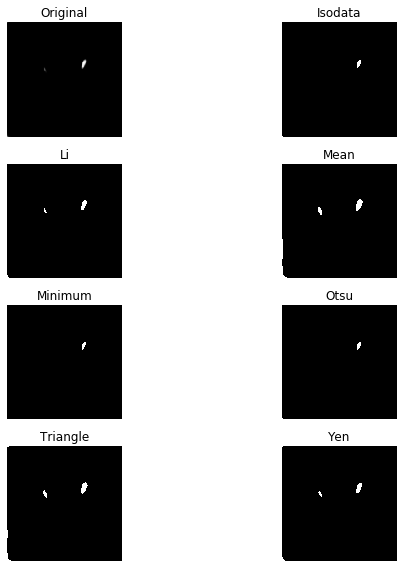

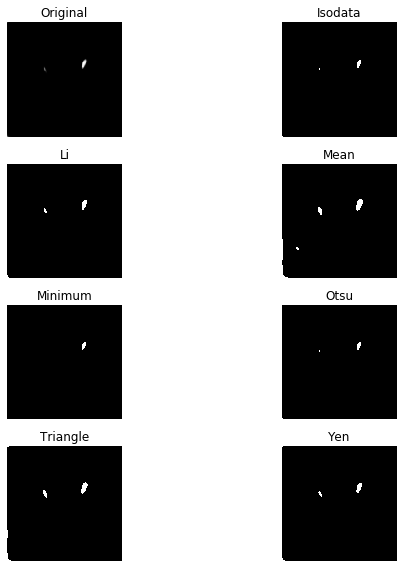

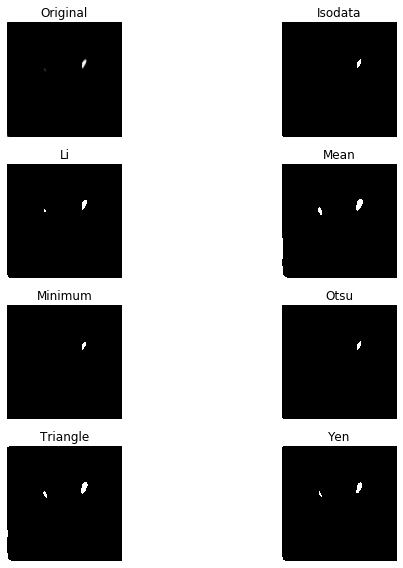

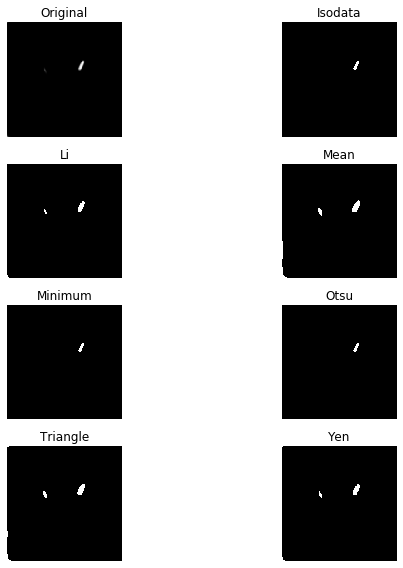

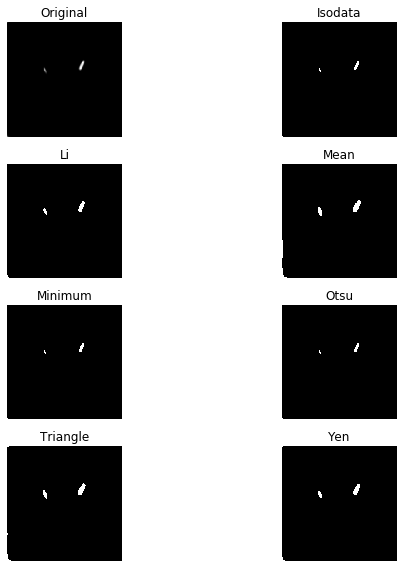

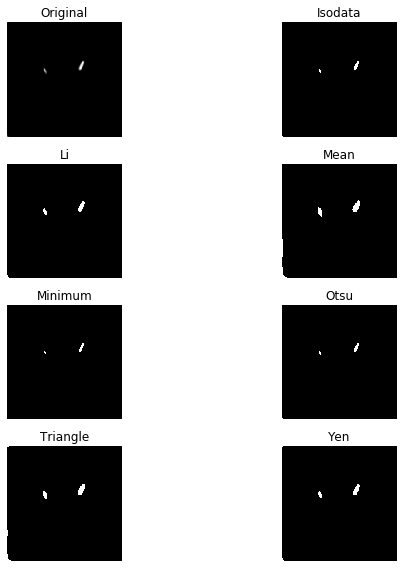

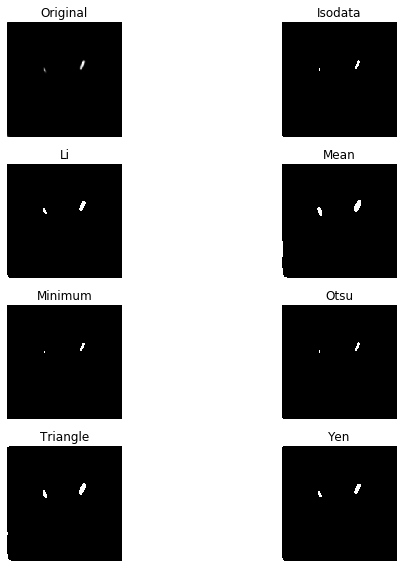

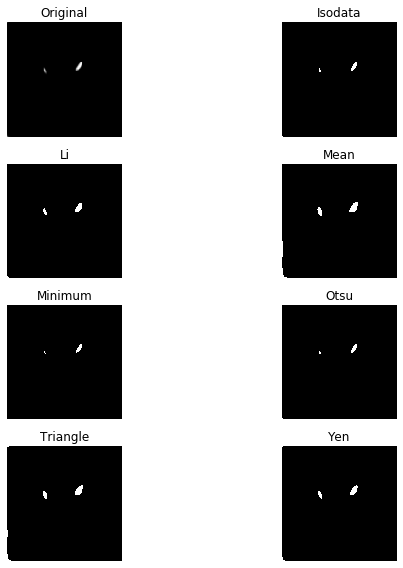

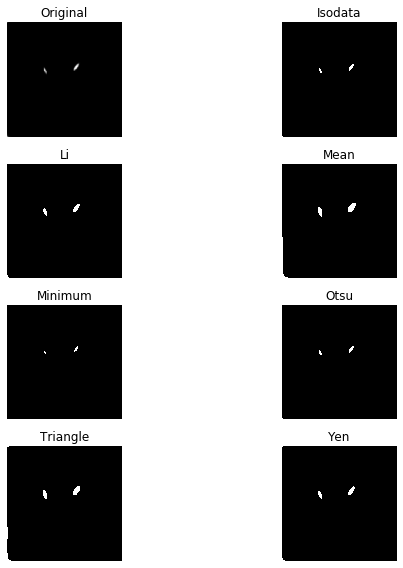

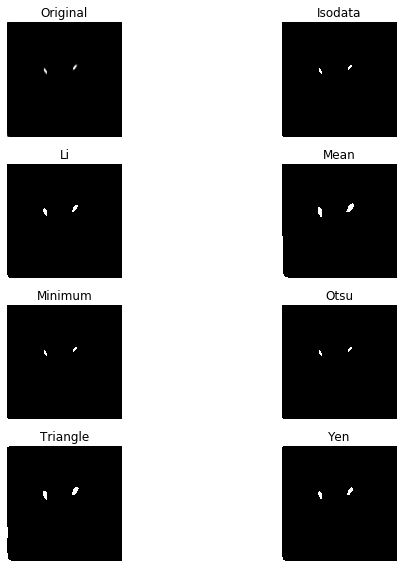

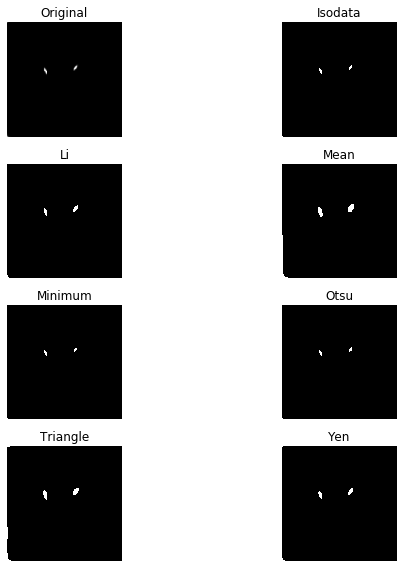

In [17]:


from skimage import data
from skimage.filters import try_all_threshold



plt.close()
for i in range(700,730):#nframes):
    x= gen2.__getitem__(i)
    result = model.predict(x)
    for batch_number in range(batch_size):
        tracked = result[batch_number].squeeze()
        blurred = tracked
        binary = blurred > threshold_otsu(blurred)

        labels = measure.label(binary,connectivity = 1)

        plots = {'Tracked': tracked, 'Blurred': blurred, 
                 'Binary': binary, 'Labels': labels}

        fig, ax = try_all_threshold(blurred, figsize=(10, 8), verbose=False)
        plt.show()




In [26]:
#visualizing the output activations of each layer.
# taken from github and this link: 
# https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

model = keras.models.load_model('model_mulitple.h5')
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
layer_outputs = [layer.output for layer in model.layers] 
# Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

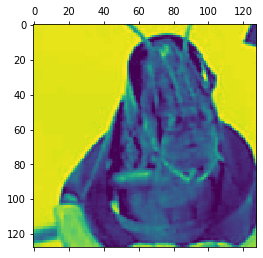

In [22]:

# get an image from a function above here!!!!!!

x= gen2.__getitem__(400)

activations = activation_model.predict(x)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

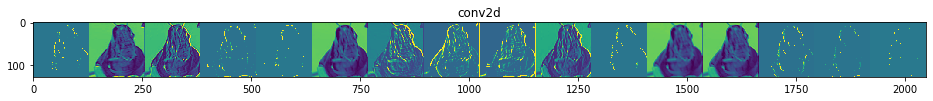

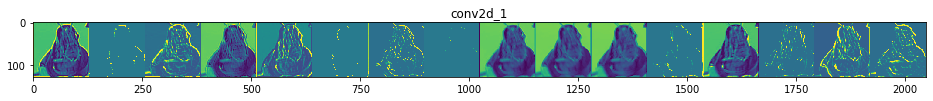

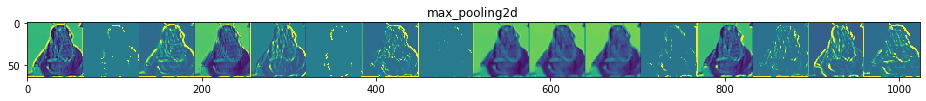

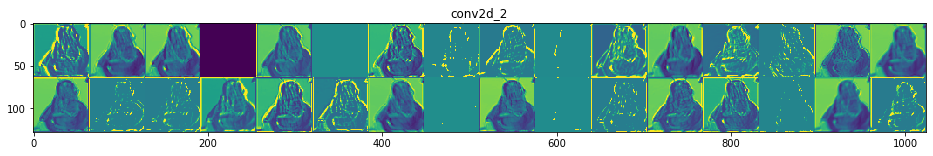

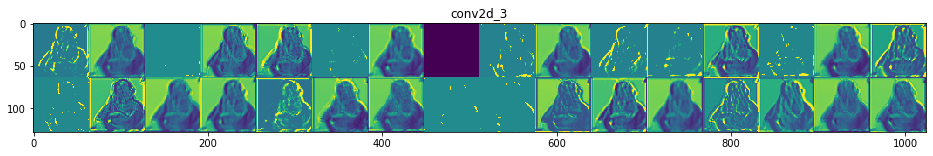

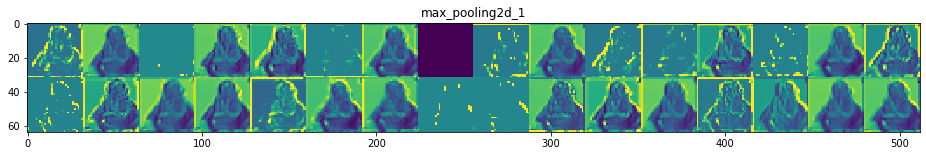

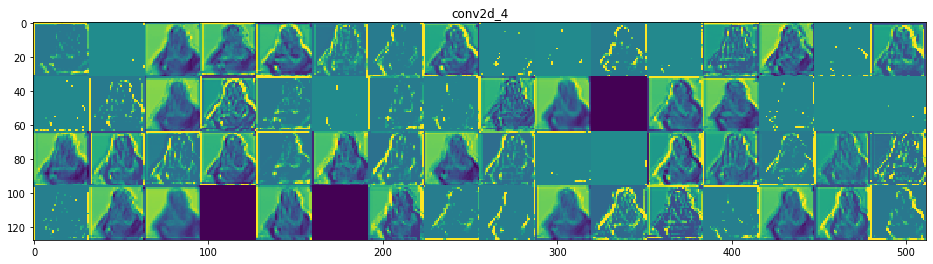

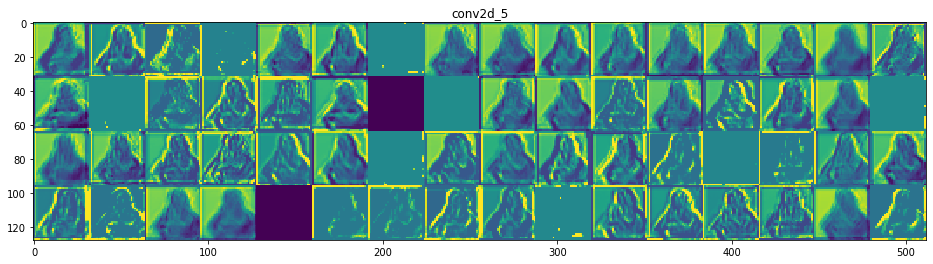

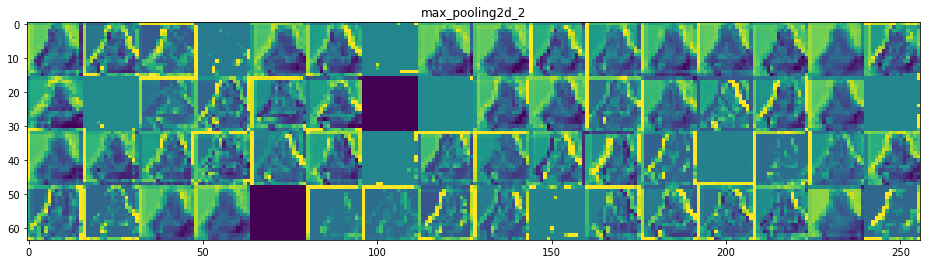

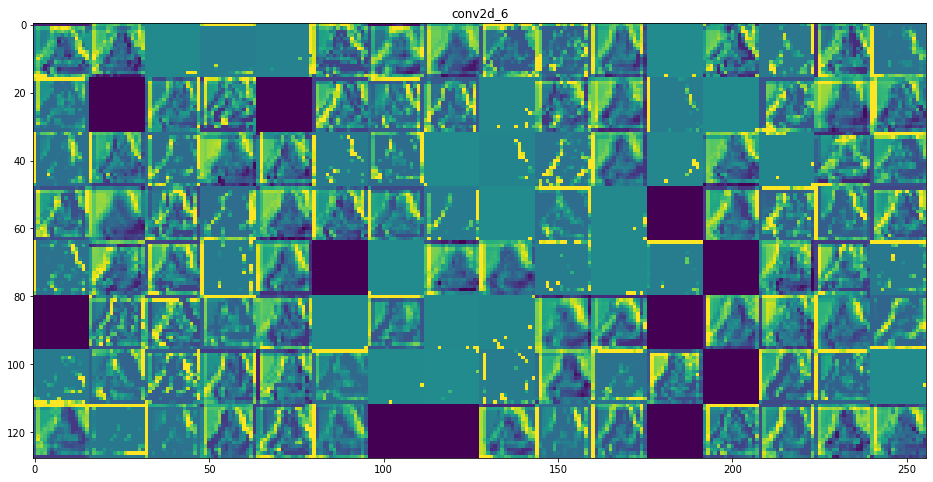

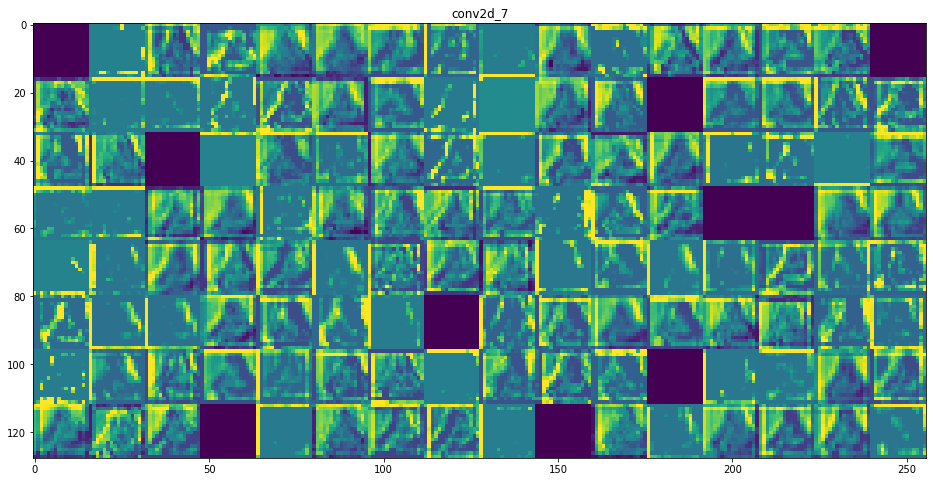

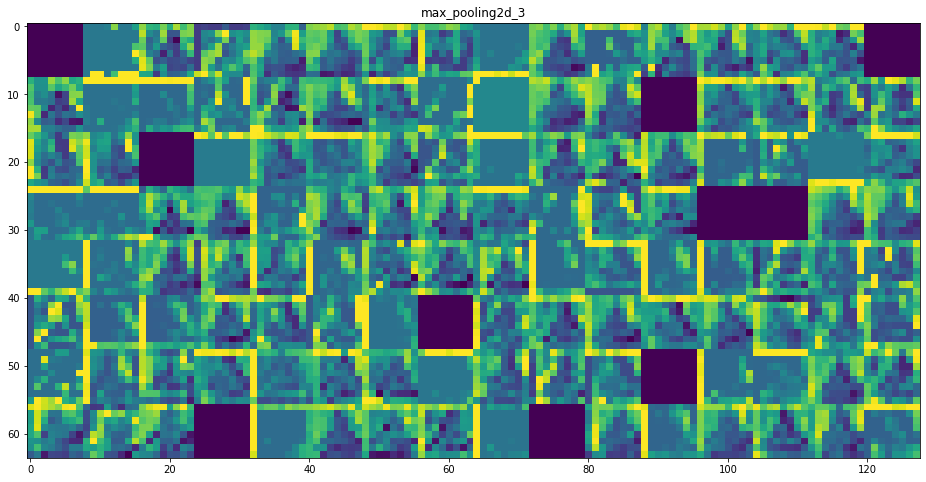

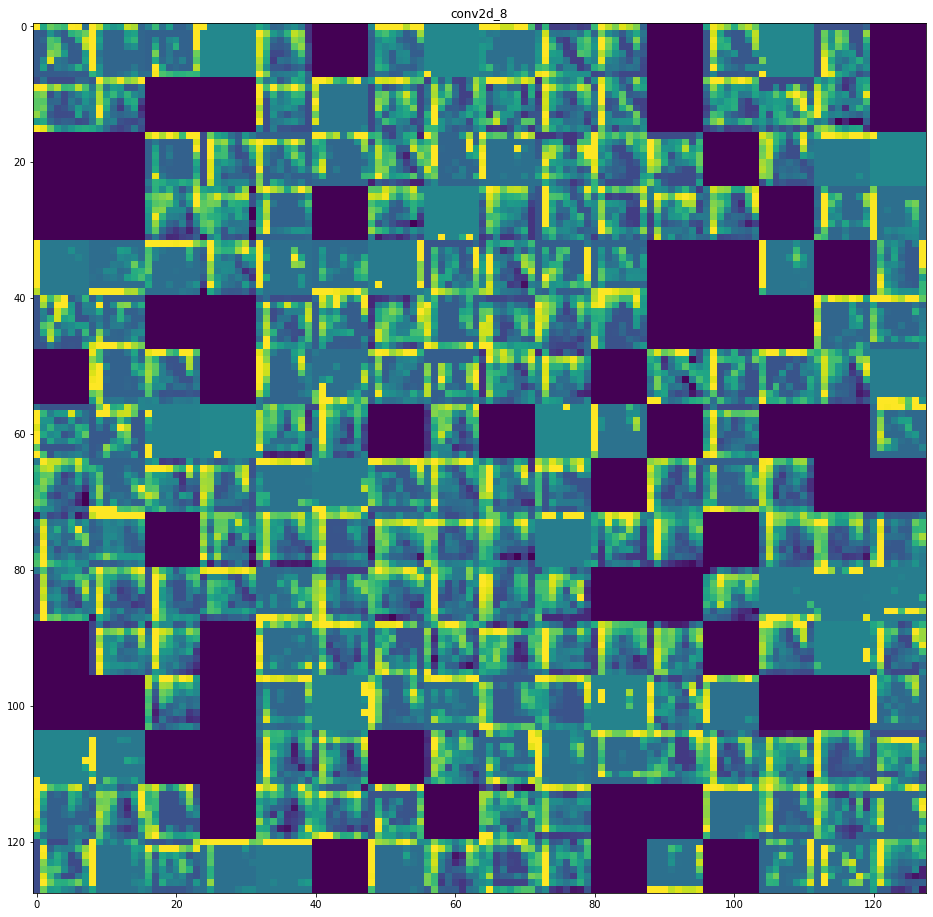

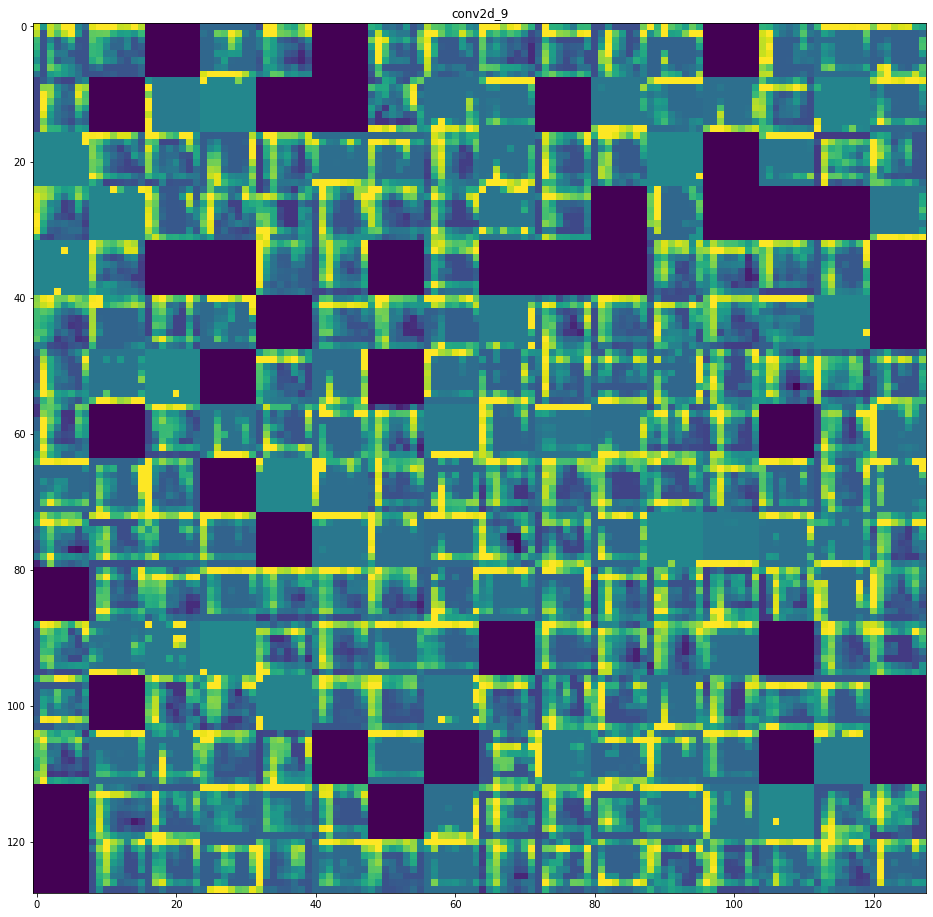

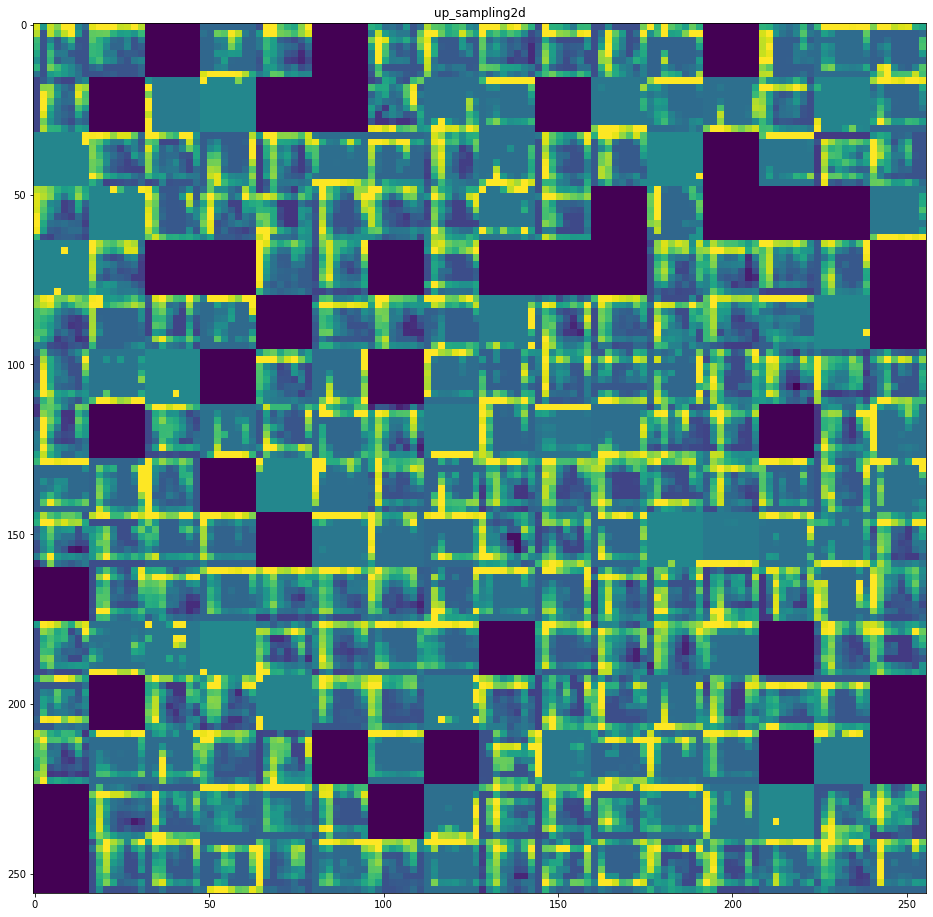

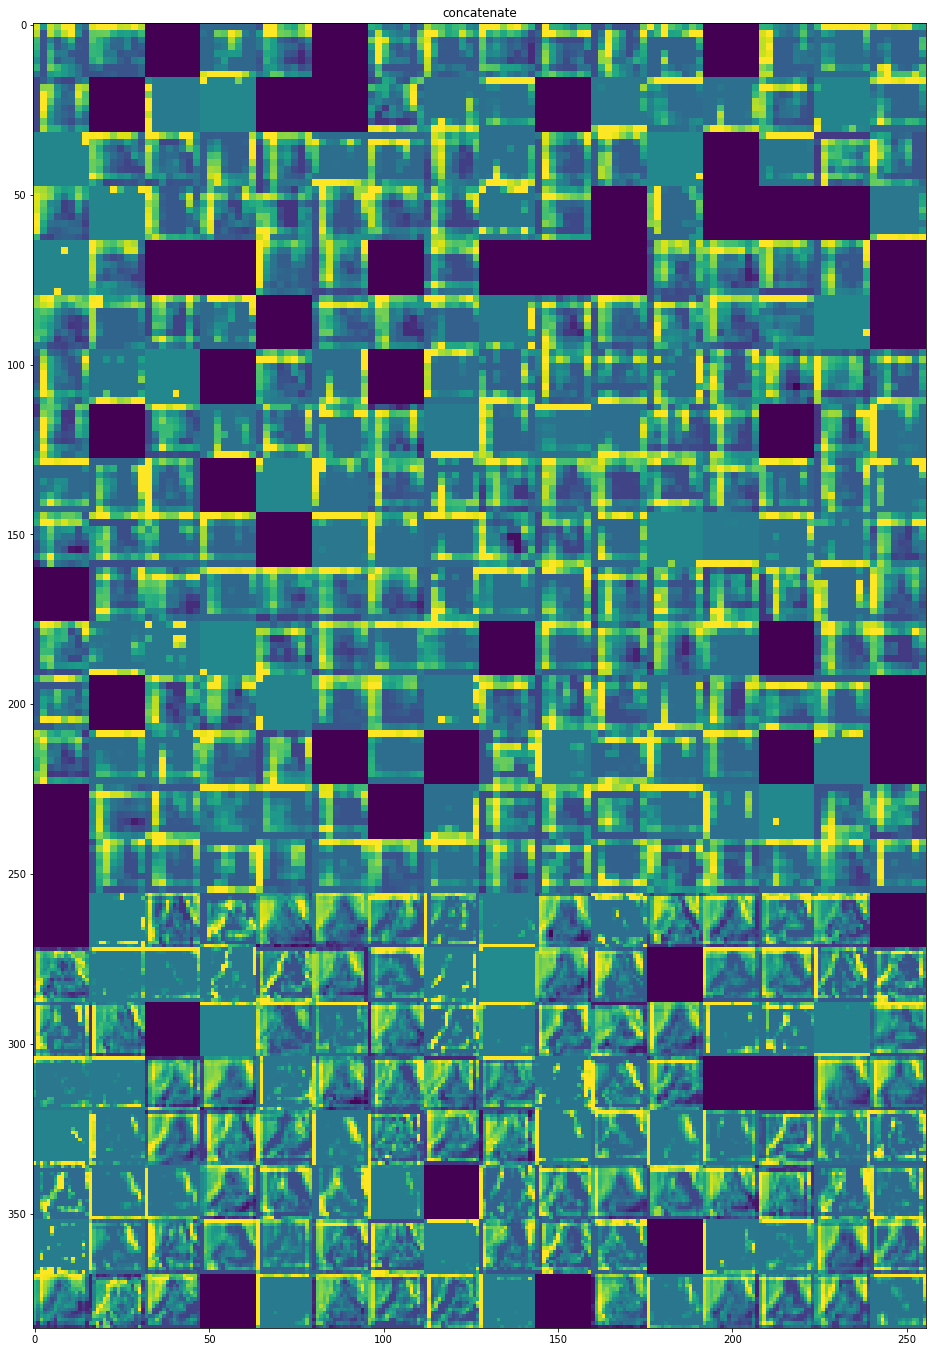

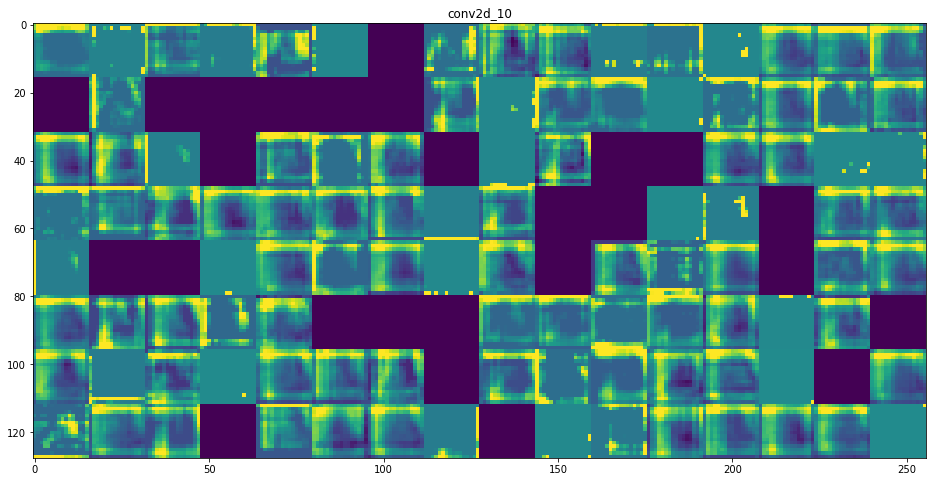

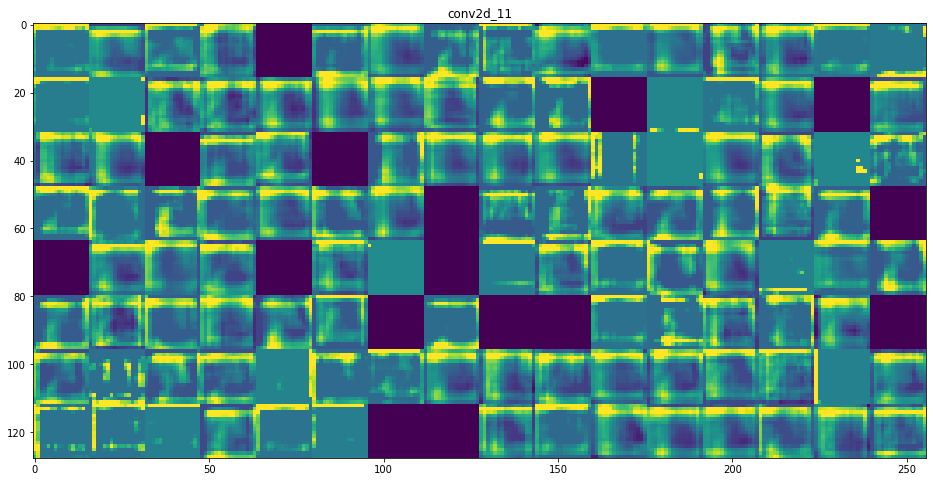

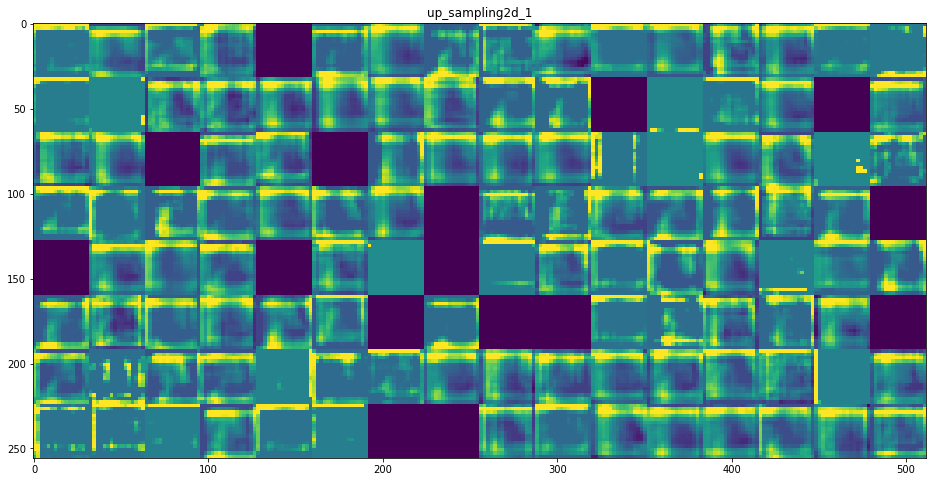

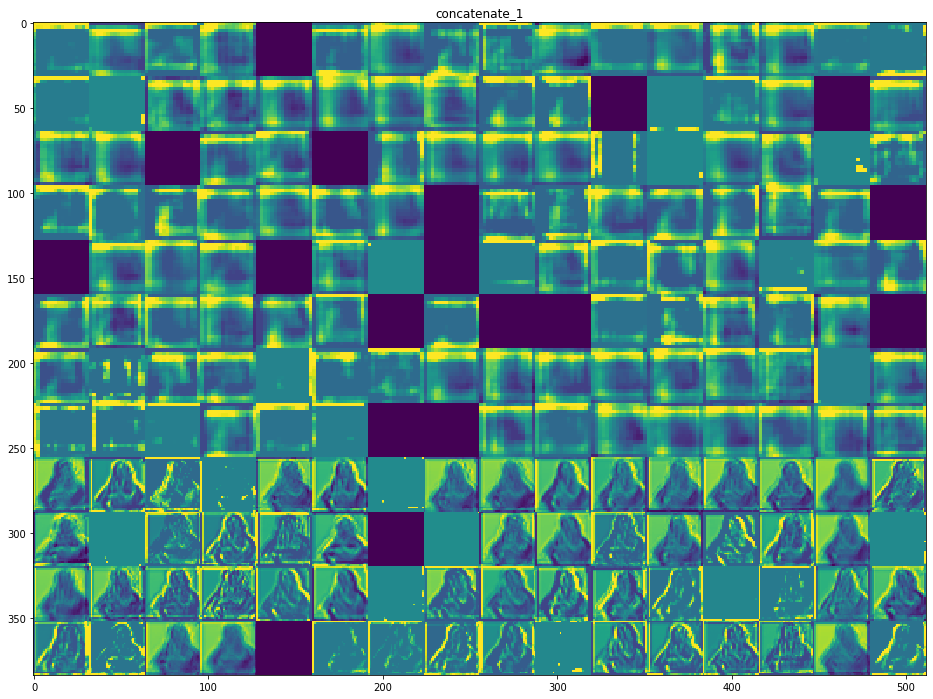

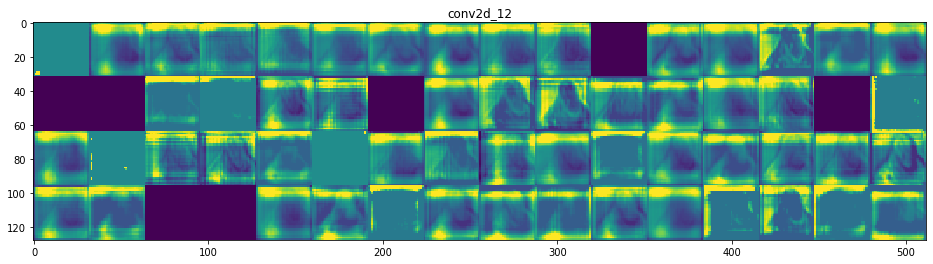

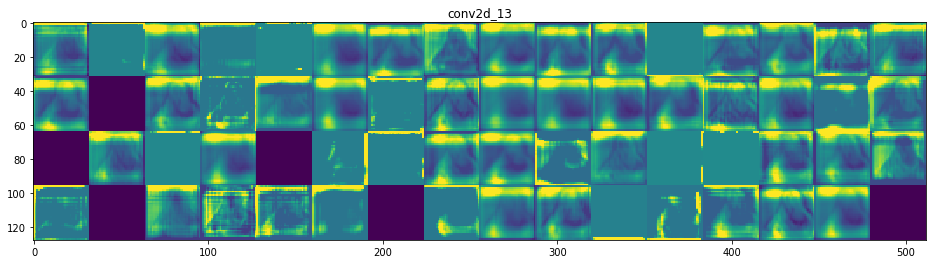

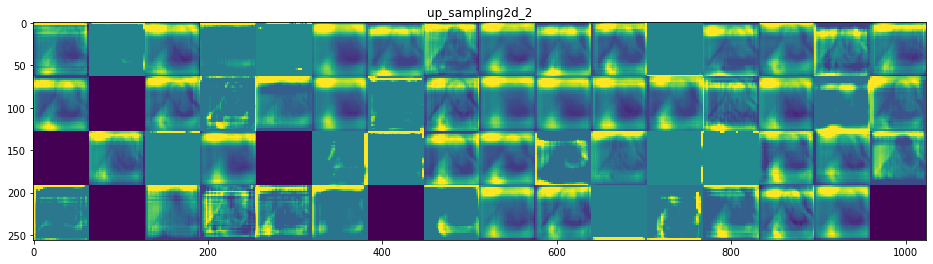

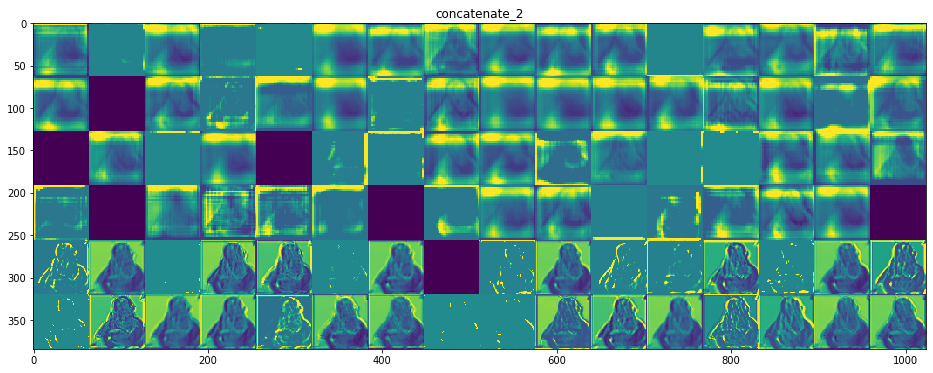

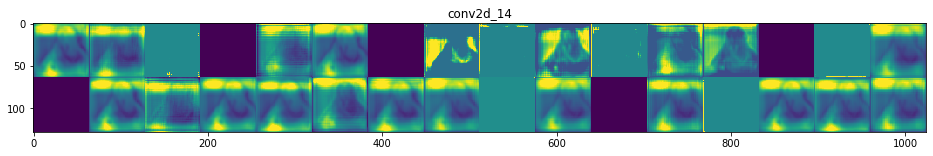

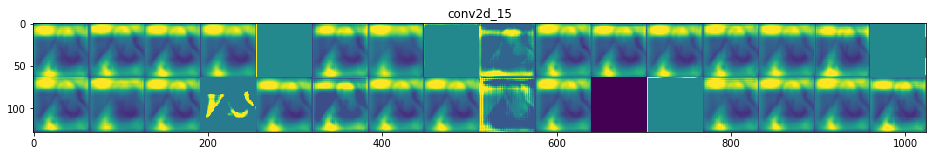

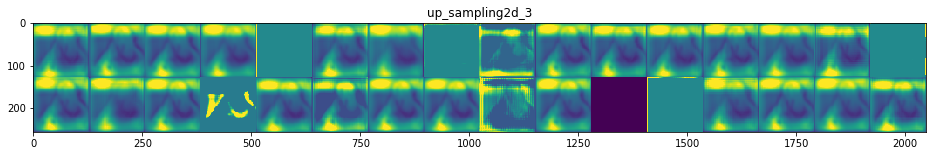

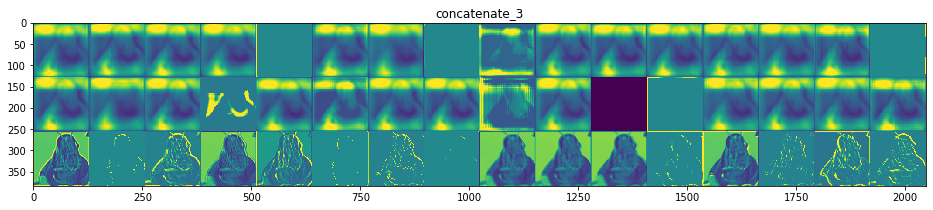

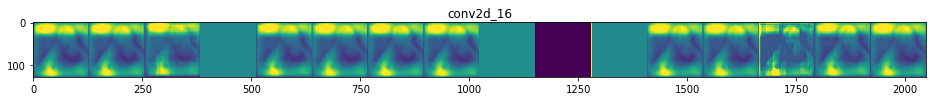

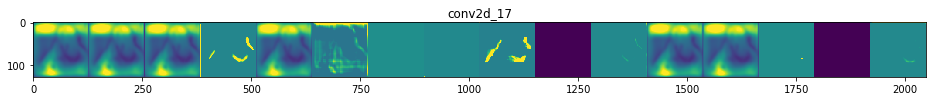

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

In [28]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## useful links for imgaug 
https://imgaug.readthedocs.io/en/latest/source/examples_segmentation_maps.html

 https://www.kaggle.com/mpalermo/keras-pipeline-custom-generator-imgaug